#Group Details


**Group Members (student ID):** August Asheim Birkelan (506753), Ørjan Carlsen (507694), Alexey Gusev (477979)

**Kaggle Competition:** Moscow Housing

**Kaggle Team:** Group 1

# Imports + Fetching Data



## Pip installs + imports

In [ ]:
pip install category_encoders -q

In [ ]:
pip install catboost==1.0.3

In [ ]:
pip install lightgbm==3.3.1

In [ ]:
pip install xgboost==1.5.0

In [ ]:
pip install missingno

In [ ]:
import json
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import GradientBoostingRegressor
import sklearn.model_selection as model_selection
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from copy import deepcopy
import lightgbm as lgb


plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')


## Fetching Data 



In [ ]:
##TRAIN
#buildings = pd.read_csv('./drive/MyDrive/MoscowHousePrises/buildings_train.csv')
buildings = pd.read_csv('buildings_train.csv')
apartments = pd.read_csv('apartments_train.csv')
print(f'All apartments have an associated building: {apartments.building_id.isin(buildings.id).all()}')
data_train = pd.merge(apartments, buildings.set_index('id'), how='left', left_on='building_id', right_index=True)
#DROPPING DUPLICATES IN TRAIN
data_train = data_train.drop_duplicates(subset=data_train.columns.difference(['id']))
##TEST
apartments_test = pd.read_csv('apartments_test.csv')
buildings_test = pd.read_csv('buildings_test.csv')
print(f'All test apartments have an associated building: {apartments_test.building_id.isin(buildings_test.id).all()}')
data_test = pd.merge(apartments_test, buildings_test.set_index('id'), how='left', left_on='building_id', right_index=True)
data_test_id = data_test.id
print("Test_set shape:", data_test.shape)
##ALL DATA
data_all = pd.concat([data_train, data_test])
data_all['Split'] = np.where(data_all['id'] <= np.max(data_train['id']), 'Train', 'Test')
#data_all = data_all.drop(['id'], axis=1) #dropping the id column since its unused
pd.set_option("display.max_rows", 2000)

All apartments have an associated building: True
All test apartments have an associated building: True
Test_set shape: (9937, 33)


In [ ]:
print("Before removing outliers:", data_all.shape)
data_all = data_all[(data_all['area_total']<1175) | (data_all['Split']=='Test')]
data_all = data_all[(data_all['price']<700000000) | (data_all['price'].isna())]
#data_all = data_all[(data_all['price']>=2500000) | (data_all['Split']=='Test')] removing outliers with too low price
print("After removing outliers:", data_all.shape)
data_train = data_all[data_all['Split']=='Train']
data_test = data_all[data_all['Split']=='Test']
print("Test_set shape:", data_test.shape)

Before removing outliers: (32757, 35)
After removing outliers: (32741, 35)
Test_set shape: (9937, 35)


# Exploratory Data Analysis (EDA)

## Search domain knowledge

**We have tried to find the expensive areas i Moscow, to use as features.** References: 

- https://www.rbth.com/travel/332318-expensive-rich-districts-moscow

- https://www.rbth.com/lifestyle/330504-most-expensive-places-moscow

- https://neighborhoodaudit.com/most-expensive-areas-in-moscow/

In [ ]:
expensive_dict = {
    'Barvikha Luxury Village'   : ( 55.73830585462612, 37.2589943157992   ),
    'Golden Mile'               : ( 55.739780529407795, 37.59647160240426 ),
    'Khamovniki'                : ( 55.73177625126226, 37.58103565593387  ),
    'Four Seasons Hotel Moscow' : ( 55.75715286468593, 37.61657109523183  ),
}

In [ ]:
import geopy.distance

for expensive_area, coordinate in expensive_dict.items():
  data_all[expensive_area] = data_all.apply(lambda row: int(geopy.distance.geodesic((row['latitude'],row['longitude']), coordinate).km < 1), axis=1)
  data_all_cat[expensive_area] = data_all_cat.apply(lambda row: int(geopy.distance.geodesic((row['latitude'],row['longitude']), coordinate).km < 1), axis=1)

**We have also tried to find some cheap neighbourhoos:**

*   https://www.reddit.com/r/russian/comments/my1y8s/dangerousrough_neighborhood_in_moscow/
*   https://www.quora.com/What-are-some-dangerous-neighborhoods-in-Moscow




In [ ]:
cheap_dict = {
    'Kapotnya'   : (  55.635127547729155, 37.798024952512705),
    'Nekrasovka' : (55.698150371373, 37.93650510 ),
    'Biryolovo'  : (55.585624161, 37.64551724743 ),
    'Yzhone' : (55.5375404538, 37.533040288  ),
}

rad_dict = {
    'Kapotnya'   : 1.3,
    'Nekrasovka' : 2.5,
    'Biryolovo'  : 1.3,
    'Yzhone' : 2.5,
}

In [ ]:
import geopy.distance

for cheap_area, coordinate in cheap_dict.items():
  stored_data_all[cheap_area] = stored_data_all.apply(lambda row: int(geopy.distance.geodesic((row['latitude'],row['longitude']), coordinate).km < rad_dict[cheap_area]), axis=1)
  stored_data_all_cat[cheap_area] = stored_data_all_cat.apply(lambda row: int(geopy.distance.geodesic((row['latitude'],row['longitude']), coordinate).km < rad_dict[cheap_area]), axis=1)

stored_data_all['cheap_area'] = stored_data_all.apply(lambda row: int((row['Kapotnya']==1 or row['Nekrasovka']==1 or row['Biryolovo']==1 or row['Yzhone']==1)), axis=1)
stored_data_all_cat['cheap_area'] = stored_data_all_cat.apply(lambda row: int((row['Kapotnya']==1 or row['Nekrasovka']==1 or row['Biryolovo']==1 or row['Yzhone']==1)), axis=1)

stored_data_all = stored_data_all.drop(['Kapotnya','Nekrasovka', 'Biryolovo', 'Yzhone'], axis=1)
stored_data_all_cat = stored_data_all_cat.drop(['Kapotnya','Nekrasovka', 'Biryolovo', 'Yzhone'], axis=1)

**The prices might be much higher close to metro stations**, according to this reference. https://www.irn.ru/articles/25110.html

We have tried to take this into account, by making features as the distance from 15 of the metros in Moscow

In [ ]:
metro_dict = {
    'Arbatskaya'           : ( 55.751880541666424 , 37.60086951943504 ),
    'Novoslobodskaya'      : ( 55.77846575901055, 37.601906727075104  ),
    'Ploschad Revolyutsii' : ( 55.75662005499246, 37.62160809821653   ), 
    'Baumanskaya'          : ( 55.77371179376982, 37.680578609370826  ),
    'Park Pobedy'          : ( 55.73594659141419, 37.51746057125134   ),
    'Taganskaya'           : ( 55.741429265244335, 37.65140305390748  ),
    'Prospekt Mira'        : ( 55.779781874649494, 37.63258198456574  ),
    'Aviamotornaya'        : ( 55.75162139850973, 37.71296391170971   ),
    'Elektrozavodskaya'    : ( 55.781228581265594, 37.70508430006628  ),
    'Kievskaya'            : ( 55.74469909774404, 37.56541418472278   ),
    'Komsomolskaya'        : ( 55.775612797693384, 37.65631831355949  ),
    'Mayakovskaya'         : ( 55.76959941478146, 37.59633290022133   ),
    'Novokuznetskaya'      : ( 55.74260115515175, 37.62888245246348   ),
    'Slavyansky Bulvar'    : ( 55.73044068690516, 37.472484955886664  ),
    'Teatralnaya'          : ( 55.757601388329284, 37.61920945588765  ),
}

## Check if data is intuituve

### Skewness and kurtosis

In [ ]:
print("Skewness: %f" % data_train['price'].skew())
print("Kurtosis: %f" % data_train['price'].kurt())
data_train['price'].describe()

Skewness: 19.132863
Kurtosis: 711.973339


count    2.282000e+04
mean     2.358935e+07
std      5.299276e+07
min      9.000000e+05
25%      7.462644e+06
50%      1.060000e+07
75%      2.050000e+07
max      2.600000e+09
Name: price, dtype: float64

### Checking if there are categorical columns that have values outside the predefined in meta 


In [ ]:
print("Buildings:")
for meta in buildings_meta:
  if meta['type'] == 'categorical':
    print(meta['name'],meta['cats'], data_all[meta['name']].unique())
print("Apartments:")
for meta in apartments_meta:
  if meta['type'] == 'categorical':
    print(meta['name'],meta['cats'], data_all[meta['name']].unique())
#There are no categorical colums having values outside predefined in meta

Buildings:
district ['Central', 'North', 'North-East', 'East', 'South-East', 'South', 'South-West', 'West', 'North-West', 'Zelenograd', 'Troitsk', 'Novomoskovsk'] [11.  2.  6. nan  5.  0.  7.  3.  4.  8.  1. 10.  9.]
material ['Bricks', 'Wood', 'Monolith', 'Panel', 'Block', 'Monolithic_brick', 'Stalin_project'] [ 3.  2. nan  0.  4.  5.  6.  1.]
parking ['Ground', 'Underground', 'Multilevel'] [ 1. nan  0.  2.]
heating ['Central', 'Individual', 'Boiler', 'Autonomous_boiler'] [nan  0.  1.  3.  2.]
Apartments:
seller ['Owner', 'Company', 'Agents', 'Developer'] [ 3. nan  1.  2.  0.]
layout ['Adjacent', 'Isolated', 'Adjacent_isolated'] [nan  1.  2.  0.]
condition ['Undecorated', 'Decorated', 'Euro_repair', 'Special_design'] [nan  3.  2.  0.  1.]


### Checking if there are real or integer columns with negative values where it shouldnt be (not intuitive)



In [ ]:
print("Buildings:")
for meta in buildings_meta:
  if meta['type'] == 'real' or meta['type'] == 'integer':
    if (data_all[data_all[meta['name']].values<0].values.any()):
      print(meta['name'])
print("Apartments:")
for meta in apartments_meta:
  if meta['type'] == 'real' or meta['type'] == 'integer':
    if (data_all[data_all[meta['name']].values<0].values.any()):
      print(meta['name'])

Buildings:
longitude
Apartments:


In [ ]:
print('Train shape = {}'.format(data_train.shape))
print('Test shape = {}'.format(data_test.shape))
print(data_all.info())

Train shape = (22820, 34)
Test shape = (9937, 33)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 32757 entries, 0 to 9936
Data columns (total 34 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   seller              20244 non-null  float64
 1   price               22820 non-null  float64
 2   area_total          32757 non-null  float64
 3   area_kitchen        25959 non-null  float64
 4   area_living         26979 non-null  float64
 5   floor               32757 non-null  float64
 6   rooms               32757 non-null  float64
 7   layout              8081 non-null   float64
 8   ceiling             16952 non-null  float64
 9   bathrooms_shared    27305 non-null  float64
 10  bathrooms_private   27305 non-null  float64
 11  windows_court       21406 non-null  float64
 12  windows_street      21406 non-null  float64
 13  balconies           17630 non-null  float64
 14  loggias             17630 non-null  float64
 15  cond

In [ ]:
print("Before removing outliers:", data_all.shape)
data_all = data_all[(data_all['area_total']<1175) | (data_all['Split']=='Test')]
data_all = data_all[(data_all['price']<700000000) | (data_all['price'].isna())]
#data_all = data_all[(data_all['price']>=2500000) | (data_all['Split']=='Test')] removing outliers with too low price
print("After removing outliers:", data_all.shape)
data_train = data_all[data_all['Split']=='Train']
data_test = data_all[data_all['Split']=='Test']
print("Test_set shape:", data_test.shape)

Before removing outliers: (32757, 35)
After removing outliers: (32741, 35)
Test_set shape: (9937, 35)


### Plotting for illustration and understanding column-values



**TRAIN**

In [ ]:
def scatter_df(y_var, dataset):
  for col in dataset.columns:
    if col=='Split':
      continue
    if col=='street' or col=='address':
      filtered_data = dataset
    else:
      filtered_data = dataset[~np.isnan(dataset[col])]
    plt.figure(figsize=(20,15))
    plot1 = sns.scatterplot(col, y_var, data = filtered_data, s = 150)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.show()
scatter_df('price', data_all[data_all['Split']=='Train'])

**TEST**

In [ ]:
def scatter_df(y_var, dataset):
  for col in dataset.columns:
    if col=='Split':
      continue
    if col=='street' or col=='address':
      filtered_data = dataset
    else:
      filtered_data = dataset[~np.isnan(dataset[col])]
    plt.figure(figsize=(20,15))
    plot1 = sns.scatterplot(col, y_var, data = filtered_data, s = 150)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.show()
scatter_df('area_total', data_all[data_all['Split']=='Test'])

In [ ]:
plt.figure(figsize=(10,10))
sns.scatterplot(x='area_total', y='price', data=data_all[data_all['Split']=='Train'])
sns.displot(data=data_all[data_all['Split']=='Train'], x="price", bins=20)

**Plotting a boxplot**

In [ ]:
plt.figure(figsize=(15,15))
sns.boxplot(x='price', data=data_train, showmeans=True)
from matplotlib.cbook import boxplot_stats  
outliers = boxplot_stats(data_all[data_all['Split']=='Train'].price).pop(0)['fliers']
outliers = sorted(outliers)
print(outliers[-1], data_all[data_all['Split']=='Train'].price.max())

**Illustrating NAN values**


In [ ]:
print("DATA_TRAIN")
print(data_train.info())
print("DATA_TEST")
print(data_test.info())
fig, (ax1, ax2) = plt.subplots(figsize=(16, 4), ncols=2, dpi=100)
print(f'Number of missing price entries in train data: {data_train.price.isna().sum()}') 
print(f'Training set features with any missing value: {data_train.isna().any().sum()}/{data_train.shape[1]}')
data_train.isna().mean().plot.bar(ax=ax1, title='Fraction of NaN values in the training set')
data_test.isna().mean().plot.bar(ax=ax2, title='Fraction of NaN values in the test set')

**Plotting map**

(<matplotlib.axes._subplots.AxesSubplot at 0x7f78ae786810>,
 <matplotlib.colors.Normalize at 0x7f77a3f93410>)

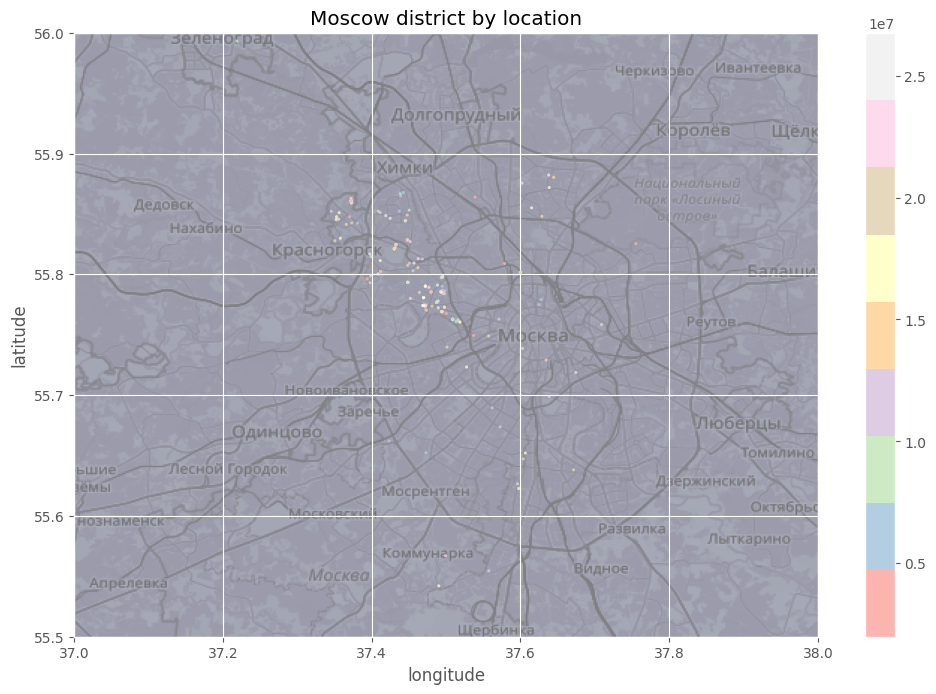

In [ ]:
from copy import deepcopy
def plot_map(data, ax=None, s=5, a=0.75, q_lo=0.0, q_hi=0.9, cmap='autumn', column='price', title='Moscow apartment price by location'):
    data = data[['latitude', 'longitude', column]].sort_values(by=column, ascending=True)
    backdrop = plt.imread('moscow.png')
    backdrop = np.einsum('hwc, c -> hw', backdrop, [0, 1, 0, 0]) ** 2
    if ax is None:
        plt.figure(figsize=(12, 8), dpi=100)
        ax = plt.gca()
    discrete = data[column].nunique() <= 20
    if not discrete:
        lo, hi = data[column].quantile([q_lo, q_hi])
        hue_norm = plt.Normalize(lo, hi)
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(lo, hi))
        sm.set_array([])
    else:
        hue_norm = None 
    ax.imshow(backdrop, alpha=0.5, extent=[37, 38, 55.5, 56], aspect='auto', cmap='bone', norm=plt.Normalize(0.0, 2))
    sns.scatterplot(x='longitude', y='latitude', hue=data[column].tolist(), ax=ax, s=s, alpha=a, palette=cmap,linewidth=0, hue_norm=hue_norm, data=data)
    ax.set_xlim(37, 38)    # min/max longitude of image 
    ax.set_ylim(55.5, 56)  # min/max latitude of image
    if not discrete:
        ax.legend().remove()
        ax.figure.colorbar(sm)
    ax.set_title(title)
    return ax, hue_norm
#NOTE: you can uncomment different ones of theese to see what we have plotted.
#data_test_fake = deepcopy(data_test)
#data_test_fake['price']=1
#plot_map(data_test_fake);
#plot_map(data_train)
#data_all[data_all['area_kitchen']+data_all['area_living']>data_all['area_total']].groupby(by='area_kitchen')
plot_map(data_all[data_all['area_kitchen']+data_all['area_living']>data_all['area_total']], cmap='Pastel1')
plot_map(data_all[~data_all['district'].isnull()], cmap='Pastel1', column='district', title='Moscow district by location')
#plot_map(data_all, cmap='Pastel1', column='lat_long_tile', title='Tiles')

## Looking at missing data



In [ ]:
import missingno
missingno.matrix(data_train)
missingno.heatmap(data_train)

In [ ]:
missingno.matrix(data_train.sort_values('new'))

print("DATA_TRAIN")
print(data_train.info())
print("DATA_TEST")
print(data_test.info())
fig, (ax1, ax2) = plt.subplots(figsize=(16, 4), ncols=2, dpi=100)
print(f'Number of missing price entries in train data: {data_train.price.isna().sum()}') 
print(f'Training set features with any missing value: {data_train.isna().any().sum()}/{data_train.shape[1]}')
data_train.isna().mean().plot.bar(ax=ax1, title='Fraction of NaN values in the training set')
data_test.isna().mean().plot.bar(ax=ax2, title='Fraction of NaN values in the test set')

## NOTE:



> **From her on we explore a lot of individual features and pairs or groups of features. For each column we clean up the values if its something we think are wrong (like the negative lat-long-values). We also try to understand how the data was generated. Like area kitchen and living we suspect sometimes is given in percentage instead of M^2.**



## Area Total + Area Kitchen + Area Living (pair)

In [ ]:
data_all[data_all['area_total']>500].plot(kind='scatter',x='area_total', y='price')

In [ ]:
#NOTE: Here we have a lot of lines that have been used for printing and understanding the relationship between area_kitchen, area_living and area_total
data_all[data_all['area_total']<data_all['area_kitchen']+data_all['area_living']]
data_all[data_all['area_total']>500]
data_all['area_kitchen'].value_counts()[:]
data_all[data_all['area_kitchen']+data_all['area_living']==100]
#We noticed that many rows had kitchen and living numbers which summed up to 100, therefore looking suspisuosly like percentages.
#Another thing we noticed was that Area living and Area Kithen often summarizes to a number greater than Area Total (there indicating percentage again)
#the code tries to edit this, but was not used.
train = data_all[data_all['Split']=='Train']
test = data_all[data_all['Split']=='Test']
train.loc[train['area_kitchen']+train['area_living']==100, 'area_kitchen'] = train['area_total']*train['area_kitchen']*0.01
test.loc[test['area_kitchen']+test['area_living']==100, 'area_kitchen'] = test['area_total']*test['area_kitchen']*0.01
train.loc[train['area_kitchen']+train['area_living']==100, 'area_living'] = train['area_total']*train['area_living']*0.01
test.loc[test['area_kitchen']+test['area_living']==100, 'area_living'] = test['area_total']*test['area_living']*0.01
test[(test['area_kitchen']+test['area_living'] > 98) & (test['area_kitchen']+test['area_living'] < 102)]
data_all[data_all['area_kitchen']+data_all['area_living']>data_all['area_total']]
#test[test['area_kitchen']+test['area_living']==100]
#data_all = train.append(test, ignore_index=True)

## Area Kitchen and Area Living Area total (2)

In the beginning we used a mean version to impute area kitchen and area living, but it was not used in the end.

In [ ]:
# all_valid_kitchens = data_all[~np.isnan(data_all['area_kitchen'])]
# all_valid_living_areas = data_all[~np.isnan(data_all['area_living'])]
# kitchen_percent = (((all_valid_kitchens['area_kitchen'])/all_valid_kitchens['area_total'])).mean()
# living_percent = (((all_valid_living_areas['area_living'])/all_valid_living_areas['area_total'])).mean()
# data_all.area_kitchen.fillna(data_all['area_total']*kitchen_percent, inplace=True)
# data_all.area_living.fillna(data_all['area_total']*living_percent, inplace=True)

## Latitutde and longitude


**Fixing the wrong values in lat and long columns.** Many points are in east Asia or in the Pacific ocean...... 

NOTE: the values are fetched from google maps by submitting the adress and street, or by looking at similar columns in the dataset.

In [ ]:
data_all.loc[(data_all['address']=='к2/2/1') & (data_all['street']=='Бунинские Луга ЖК') & (data_all['longitude']<0), ['latitude', 'longitude']] = [55.544046, 37.478055]
data_all.loc[(data_all['address']=='к2/2/2') & (data_all['street']=='Бунинские Луга ЖК') & (data_all['longitude']<0), ['latitude', 'longitude']] = [55.544886, 37.478459] 
data_all.loc[data_all['address'] == 'Москва А101 ЖК', ['latitude', 'longitude']] = [55.560891,	37.473761]
data_all.loc[(data_all['street']=='улица Центральная') & (data_all['address']=='48'), ['latitude', 'longitude']] = [55.853511, 37.384711]	 #[55.809245, 37.350090]
data_all.loc[(data_all['street']=='улица Центральная') & (data_all['address']=='75'), ['latitude', 'longitude']] = [55.853511, 37.384711]   #[55.809245, 37.350090]

## District

**Imputing district based on lat long position ( the district position is based on the map-plot which is grouped by district)** It is also based on other rows in the dataset that is not missing district.

In [ ]:
pd.set_option("display.max_rows", 2000)
data_all.loc[(data_all['latitude']==55.595160) & (data_all['longitude']==37.741109) & (data_all['district'].isnull()), 'district'] = 5
data_all.loc[(data_all['latitude']==17.141734) & (data_all['longitude']==-61.790500) & (data_all['district'].isnull()), 'district'] = 11
data_all.loc[(data_all['latitude']==55.583537) & (data_all['longitude']==37.478025	) & (data_all['district'].isnull()), 'district'] = 11
data_all.loc[(data_all['latitude']==55.583551) & (data_all['longitude']==37.711356) & (data_all['district'].isnull()), 'district'] = 5
data_all.loc[(data_all['street']=='В мкр') & (data_all['district'].isnull()), 'district'] = 2
data_all.loc[(data_all['street']=='улица 1-я Линия') & (data_all['district'].isnull()), 'district'] = 3
data_all.loc[(data_all['street']=='улица Центральная') & (data_all['district'].isnull()), 'district'] = 11
data_all.loc[(data_all['address']=='Москва А101 ЖК') & (data_all['district'].isnull()), 'district'] = 11
data_all.loc[(data_all['street']=='Бунинские Луга ЖК') & (data_all['district'].isnull()), 'district'] = 11
data_all[data_all['district'].isnull()].sort_values(by=['longitude'])

,id,seller,price,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,bathrooms_shared,bathrooms_private,windows_court,windows_street,balconies,loggias,condition,phones,building_id,new,latitude,longitude,district,street,address,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating,Split


## Bathrooms Shared and Bathrooms Private

### Use median of bathrooms for same building to fill in for NaN

**We fill in missing values for bathrooms_shared based on the number of shared bathrooms for other apartments in the same building**

In [ ]:
data_all["bathrooms_shared"] = data_all.groupby("building_id").transform(lambda x: x.fillna(x.median()))["bathrooms_shared"]
# data_all["bathrooms_private"] = data_all.groupby("building_id").transform(lambda x: x.fillna(x.median()))["bathrooms_private"]

## Constructed + New (pair)


Using constructed-value to impute new and new to impute constructed. This snippet was not used in the short notebook.

In [ ]:
import random
#NOTE: THIS CODE IS FROM  A STACK OVERFLOW PAGE (ON RANDOM DISTRIBUTION)

def findCeil(arr, r, l, h) :
 
    while (l < h) :   
        mid = l + ((h - l) >> 1); # Same as mid = (l+h)/2
        if r > arr[mid] :
            l = mid + 1
        else :
            h = mid
     
    if arr[l] >= r :
        return l
    else :
        return -1

def myRand(arr, freq, n) :
 
    # Create and fill prefix array
    prefix = [0] * n
    prefix[0] = freq[0]
    for i in range(n) :
        prefix[i] = prefix[i - 1] + freq[i]
 
    # prefix[n-1] is sum of all frequencies.
    # Generate a random number with
    # value from 1 to this sum
    r = random.randint(0, prefix[n - 1]) + 1
 
    # Find index of ceiling of r in prefix array
    indexc = findCeil(prefix, r, 0, n - 1)
    return arr[indexc]

In [ ]:
constructed_is_nan = data_all[np.isnan(data_all['constructed'])]
constructed_is_nan_new_is_nnan = constructed_is_nan[~np.isnan(constructed_is_nan['new'])]

new_is_nan = data_all[np.isnan(data_all['new'])]
new_is_nan_constructed_is_nnan = new_is_nan[~np.isnan(new_is_nan['constructed'])]

new_is_nnan = data_all[data_all['new']==1]

#filling in the values for constructed if new
distribution = data_all[data_all['new']==1].groupby('constructed').count().area_total.tolist()
years = data_all[data_all['new']==1].constructed.unique().tolist()
years = [x for x in years if str(x) != 'nan']
years.sort()
data_all.loc[(np.isnan(data_all['constructed'])) & (data_all['new']==1), 'constructed'] = myRand(years, distribution, len(years))
#data_all[data_all['new']==1].constructed.isna().sum()
data_all[np.isnan(data_all['constructed'])]

#filling in the values for constructed if not new
distribution = data_all[data_all['new']==0].groupby('constructed').count().area_total.tolist()
years = data_all[data_all['new']==0].constructed.unique().tolist()
years = [x for x in years if str(x) != 'nan']
years.sort()
data_all.loc[(np.isnan(data_all['constructed'])) & (data_all['new']==0), 'constructed'] = myRand(years, distribution, len(years))
# #data_all[data_all['new']==1].constructed.isna().sum()
buildings_with_nan_constructed = data_all[np.isnan(data_all['constructed'])]


In [ ]:
constructed_mean = round(data_all["constructed"].mean(), 0)
data_all["constructed"].fillna(value=constructed_mean, inplace=True)

## Ceiling

**We noticed that ceiling-values where grouped around what we thought was Centimeters, Desimeters and Meters. Therefore we have normalized these values into Meters**. This is an example of researching how the data was generated.

In [ ]:
train = data_all[data_all['Split']=='Train']
test = data_all[data_all['Split']=='Test']
train.loc[(train['ceiling']>8) & (train['ceiling']<150), 'ceiling'] = train['ceiling']*0.1
test.loc[(test['ceiling']>8) & (test['ceiling']<150), 'ceiling'] = test['ceiling']*0.1
train.loc[(train['ceiling']>150), 'ceiling'] = train['ceiling']*0.01
test.loc[(test['ceiling']>150), 'ceiling'] = test['ceiling']*0.01
data_all = train.append(test, ignore_index=True)
data_all.loc[(data_all['ceiling']<1.7), 'ceiling'] = data_all['ceiling'].mean()

## Street and Address

Converting street and adress to bag of words, or integers. 


In [ ]:
unique_street = data_all['street'].unique()
street_map = dict([(y,x+1) for x,y in enumerate(sorted(unique_street))])
data_all['street'] = data_all['street'].apply(lambda x: street_map[x])
unique_address = data_all['address'].unique()
address_map = dict([(y,x+1) for x,y in enumerate(sorted(unique_address))])
data_all['address'] = data_all['address'].apply(lambda x: address_map[x])
data_all[['street', 'address']]

,street,address
0,304,2187
1,1729,364
2,871,1146
3,1729,364
4,1758,606
...,...,...
32736,1695,71
32737,430,2015
32738,854,1667
32739,1387,1


##Seller

**We accomplished a little bit better score after binning Seller into two categories. The binning is based on a group-by plot.**

In [ ]:
data_all.loc[(data_all['seller']==2), 'seller'] = 0
data_all.loc[(data_all['seller']==3), 'seller'] = 1

## Elevator without and high building (not tried, only sketch)

In [ ]:
print(data_all[(data_all['stories']>50) & (data_all['elevator_without']==1) & (data_all['elevator_service']==0) & (data_all['Split']=='Train')].price.describe())
data_all.price.describe()
data_all[(data_all['stories']>20) & (data_all['elevator_without']==1) & (data_all['elevator_service']==0) & (data_all['Split']=='Train')]

##Floor and Stories (not tried, only sketch)


In [ ]:
data_all[data_all['floor']>data_all['stories']]

In [ ]:
def floor(row):
  if row['stories'] == row['floor']:
    return 1
  if row['floor'] == 0:
    return 0
  return ()
data_all['floor_placement'] = data_all.apply(lambda row: floor(row), axis=1)


2

In [ ]:
data_all['floor'][data_all['floor'] > data_all['stories']] = data_all['stories']


# Predictors (Models)

**We have used several different predictors in the project: Weighted average (where weights are based on performance on K-Fold cross validation), stacking, and a combination of these two. Within both weighted average and stacking, several different models have been tried**

We have also experimented with different logarithms of price, tuning hyperparameters, using same model with different hyperparameters, changing meta-model etc.

### Weighted average

In [ ]:
model1 = RandomForestRegressor(
    n_estimators=200,
    n_jobs=-1,
    random_state=SEED,
    verbose=1,
).fit(X_CatBoost_train, y_train)
rf_test_prediction = model1.predict(X_CatBoost_test)

In [ ]:
model2 = GradientBoostingRegressor(
    n_estimators=600,
    learning_rate=0.06,
    min_samples_leaf=4, 
    max_depth=9, 
    random_state=SEED,
    verbose=1,
).fit(X_GB_train, y_train)
gb_test_prediction = model2.predict(X_GB_test)

In [ ]:
model3 = lgb.LGBMRegressor(
    n_estimators=6000,
    learning_rate=0.08,
    num_leaves=10,
    random_state=SEED,
    seed=SEED,
    n_jobs=-1,
    categorical_feature = lgbm_categorical,
).fit(X_LGB_train, y_train)
lgb_test_prediction = model3.predict(X_LGB_test)

In [ ]:
model4 = xgb.XGBRegressor(
    n_estimators=4000,
    learning_rate=0.14,
    max_depth = 6,
    n_iter_no_change = 3,
    objective='reg:squarederror',
    n_jobs=-1, 
    random_state=SEED,
    seed=SEED,
    verbosity=1,
).fit(X_XGBoost_train, y_train)
xgb_test_prediction = model4.predict(X_XGBoost_test)

In [ ]:
model5 = CatBoostRegressor(
    n_estimators=4500,
    learning_rate=0.1,
    thread_count=-1,
    depth=9,
    random_seed=SEED,
    silent=True,
).fit(X_CatBoost_train, y_train)
cat_test_prediction = model5.predict(X_CatBoost_test)

In [ ]:
avg_prediction = np.average(
    [
     rf_test_prediction,
     gb_test_prediction,
     lgb_test_prediction,
     xgb_test_prediction,
     cat_test_prediction,
    ],
    # acc Dataframe is created when testing cross validation with 4 folds, containing mean rmsle for each model
    weights = 1 / acc['RMSLE']**9,
    axis=0
)
avg_prediction

In [ ]:
final_predictions = np.power(2, avg_prediction)
final_predictions

array([27393257.38732836,  9196293.58119236,  6227610.26571151, ...,
        9796391.97206722,  9941806.98937696,  7063032.50144758])

### Stacking

In [ ]:
# This function is taken from the ensembling lecture this fall
def get_oof(clf, x_train, y_train, x_test):
    """
    Popular function on Kaggle.
    
    Trains a classifier on 4/5 of the training data and
    predicts the rest (1/5). This procedure is repeated for all 5 folds,
    thus we have predictions for all training set. This prediction is one
    column of meta-data, later on used as a feature column by a meta-algorithm.
    We predict the test part and average predictions across all 5 models.
    
    Keyword arguments:
    clf -- classifier
    x_train -- 4/5 of training data
    y_train -- corresponding labels
    x_test -- all test data
    
    """
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.fit(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [ ]:
model1 = RandomForestRegressor(
    n_estimators=1500,
    n_jobs=-1,
    random_state=SEED,
    verbose=1,
)
model2 = GradientBoostingRegressor(
    n_estimators=600,
    learning_rate=0.06,
    min_samples_leaf=4, 
    max_depth=9, 
    random_state=SEED,
    verbose=1,
)
model3 = lgb.LGBMRegressor(
    n_estimators=6000,
    learning_rate=0.08,
    num_leaves=10,
    random_state=SEED,
    seed=SEED,
    n_jobs=-1,
    categorical_feature = lgbm_categorical,
)
model4 = xgb.XGBRegressor(
    n_estimators=5000,
    learning_rate=0.14,
    n_jobs=-1, 
    random_state=SEED,
    max_depth = 4,
    seed=SEED,
    verbosity=1,
)
model5 = CatBoostRegressor(
    n_estimators=2500,
    learning_rate=0.1,
    thread_count=-1,
    depth=9,
    random_seed=SEED,
    silent=True,
#     cat_features = ["layout", "condition", "new", "material", "seller", "parking", "heating", "district"],
)

In [ ]:
ntrain = X_train.shape[0]
ntest = X_test.shape[0]
SEED = 42 # for reproducibility
NFOLDS = 5 # set number of folds for out-of-fold prediction
kf = KFold(
    n_splits=NFOLDS,
    shuffle=True,
    random_state=SEED
) # K-Folds cross-validator

In [ ]:
X_train = X_train.values
X_test = X_test.values
X_train_cat = X_train_cat.values
X_test_cat = X_test_cat.values
y_train = y_train.ravel()

In [ ]:
rf_oof_train, rf_oof_test = get_oof(model1, X_train, y_train, X_test)
gb_oof_train, gb_oof_test = get_oof(model2, X_train, y_train, X_test)
lgb_oof_train, lgb_oof_test = get_oof(model3, X_train_cat, y_train, X_test_cat)
xgb_oof_train, xgb_oof_test = get_oof(model4, X_train, y_train, X_test) # set reg:squarederror?
cat_oof_train, cat_oof_test = get_oof(model5, X_train_cat, y_train, X_test_cat)

In [ ]:
x_train = np.concatenate((
    rf_oof_train,
    gb_oof_train,
    lgb_oof_train,
    xgb_oof_train,
    cat_oof_train
), axis=1)

x_test = np.concatenate((
    rf_oof_test,
    gb_oof_test,
    lgb_oof_test,
    xgb_oof_test,
    cat_oof_test
), axis=1)

In [ ]:
# META_MODEL = lgb.LGBMRegressor(
#     num_leaves=5,
#     max_depth=7, 
#     random_state=SEED, 
#     silent=True, 
#     metric='mse',
#     n_jobs=4, 
#     n_estimators=200,
#     colsample_bytree=1,
#     subsample=0.9,
#     learning_rate=0.05
# )
META_MODEL = RidgeCV(
    # n_jobs=-1,
)
META_MODEL.fit(x_train, y_train)
final_predictions = np.power(2, META_MODEL.predict(x_test))

# final_predictions = np.average(
#     [
#      rf_oof_test,
#      gb_oof_test,
#      lgb_oof_test,
#      xgb_oof_test,
#      cat_oof_test
#     ],
#     weights = 1 / acc['RMSLE']**9,
#     axis=0
# )
# final_predictions = np.power(2, final_predictions)
final_predictions

### Average of predictors

**Submission 1 - Stacking med 5 modeller, RidgeCV, log2**

In [ ]:
model1 = RandomForestRegressor(
    n_estimators=1500,
    n_jobs=-1,
    random_state=SEED,
    verbose=1,
)
model2 = GradientBoostingRegressor(
    n_estimators=600,
    learning_rate=0.06,
    min_samples_leaf=4, 
    max_depth=9, 
    random_state=SEED,
    verbose=1,
)
model3 = lgb.LGBMRegressor(
    n_estimators=6000,
    learning_rate=0.08,
    num_leaves=10,
    random_state=SEED,
    seed=SEED,
    n_jobs=-1,
    categorical_feature = lgbm_categorical,
)
model4 = xgb.XGBRegressor(
    n_estimators=5000,
    learning_rate=0.14,
    n_jobs=-1, 
    random_state=SEED,
    max_depth = 4,
    seed=SEED,
    verbosity=1,
)
model5 = CatBoostRegressor(
    n_estimators=2500,
    learning_rate=0.1,
    thread_count=-1,
    depth=9,
    random_seed=SEED,
    silent=True,
)

In [ ]:
data_train_all = deepcopy(data_all[data_all['Split']=='Train'].drop(['Split'], axis=1))
data_test_all  = deepcopy(data_all[data_all['Split']=='Test' ].drop(['Split'], axis=1))

data_train_cat = deepcopy(data_all_cat[data_all_cat['Split']=='Train'].drop(['Split'], axis=1))
data_test_cat  = deepcopy(data_all_cat[data_all_cat['Split']=='Test' ].drop(['Split'], axis=1))

X_train = data_train_all.drop('price', axis=1)
X_test  = data_test_all.drop('price', axis=1)

X_train_cat = data_train_cat.drop('price', axis=1)
X_test_cat  = data_test_cat.drop('price', axis=1)

y_train = np.log2(data_train_all.loc[X_train.index].price)

In [ ]:
ntrain = X_train.shape[0]
ntest = X_test.shape[0]
SEED = 42 
NFOLDS = 5
kf = KFold(
    n_splits=NFOLDS,
    shuffle=True,
    random_state=SEED
)

In [ ]:
X_train = X_train.values
X_test  = X_test.values
X_train_cat = X_train_cat.values
X_test_cat  = X_test_cat.values
y_train = y_train.ravel()

In [ ]:
rf_oof_train, rf_oof_test   = get_oof(model1, X_train, y_train, X_test)
gb_oof_train, gb_oof_test   = get_oof(model2, X_train, y_train, X_test)
lgb_oof_train, lgb_oof_test = get_oof(model3, X_train_cat, y_train, X_test_cat)
xgb_oof_train, xgb_oof_test = get_oof(model4, X_train, y_train, X_test)
cat_oof_train, cat_oof_test = get_oof(model5, X_train, y_train, X_test)

In [ ]:
x_train = np.concatenate((
    rf_oof_train,
    gb_oof_train,
    lgb_oof_train,
    xgb_oof_train,
    cat_oof_train
), axis=1)

x_test = np.concatenate((
    rf_oof_test,
    gb_oof_test,
    lgb_oof_test,
    xgb_oof_test,
    cat_oof_test
), axis=1)

In [ ]:
META_MODEL = RidgeCV()
META_MODEL.fit(x_train, y_train)
final_predictions = np.power(2, META_MODEL.predict(x_test))
final_predictions

**Submission 2 - Stacking med 3 modeller, LinearRegressor, log15**

In [ ]:
model1 = lgb.LGBMRegressor(
    n_estimators=8000,
    learning_rate=0.0715,
    num_leaves=11,
    random_state=SEED, 
    seed=SEED,
    n_jobs=-1,
    categorical_feature = lgbm_categorical,
)
model2 = xgb.XGBRegressor(
    n_estimators=7000,
    learning_rate=0.11,
    n_jobs=-1, 
    random_state=SEED,
    max_depth = 4,
    seed=SEED,
    verbosity=1,
)
model3 = CatBoostRegressor(
    n_estimators=6000,
    learning_rate=0.09,
    thread_count=-1,
    depth=9,
    random_seed=SEED,
    silent=True,
)

In [ ]:
X_CatBoost_train = deepcopy(data_CatBoost[data_CatBoost['Split']=='Train'].drop(['price', 'Split'], axis=1))
X_CatBoost_test  = deepcopy(data_CatBoost[data_CatBoost['Split']=='Test'].drop(['price', 'Split'], axis=1))

X_XGBoost_train  = deepcopy(data_XGBoost[data_XGBoost['Split']=='Train'].drop(['price', 'Split'], axis=1))
X_XGBoost_test   = deepcopy(data_XGBoost[data_XGBoost['Split']=='Test'].drop(['price', 'Split'], axis=1))

X_LGB_train      = deepcopy(data_LGB[data_LGB['Split']=='Train'].drop(['price', 'Split'], axis=1))
X_LGB_test       = deepcopy(data_LGB[data_LGB['Split']=='Test'].drop(['price', 'Split'], axis=1))

y_train = deepcopy(np.log(data_all[data_all['Split']=='Train'].price.to_numpy()) / np.log(15))

In [ ]:
ntrain = X_CatBoost_train.shape[0]
ntest = X_CatBoost_test.shape[0]
SEED = 42 
NFOLDS = 5
kf = KFold(
    n_splits=NFOLDS,
    shuffle=True,
    random_state=SEED
)

In [ ]:
X_CatBoost_train = X_CatBoost_train.values
X_CatBoost_test = X_CatBoost_test.values
X_XGBoost_train = X_XGBoost_train.values
X_XGBoost_test = X_XGBoost_test.values
X_LGB_train = X_LGB_train.values
X_LGB_test = X_LGB_test.values
y_train = y_train.ravel()

In [ ]:
lgb_oof_train, lgb_oof_test = get_oof(model1, X_LGB_train, y_train, X_LGB_test)
xgb_oof_train, xgb_oof_test = get_oof(model2, X_XGBoost_train, y_train, X_XGBoost_test)
cat_oof_train, cat_oof_test = get_oof(model3, X_CatBoost_train, y_train, X_CatBoost_test)

In [ ]:
x_train = np.concatenate((
    lgb_oof_train,
    xgb_oof_train,
    cat_oof_train
), axis=1)

x_test = np.concatenate((
    lgb_oof_test,
    xgb_oof_test,
    cat_oof_test
), axis=1)

In [ ]:
META_MODEL = LinearRegression(n_jobs=-1)
META_MODEL.fit(x_train, y_train)
final_predictions = np.power(15, META_MODEL.predict(x_test))
final_predictions

**Submission 3 - Weighted average with 5 models, log15**

In [ ]:
data_train_all = deepcopy(data_all[data_all['Split']=='Train'].drop(['Split'], axis=1))
data_test_all  = deepcopy(data_all[data_all['Split']=='Test' ].drop(['Split'], axis=1))

data_train_cat = deepcopy(data_all_cat[data_all_cat['Split']=='Train'].drop(['Split'], axis=1))
data_test_cat  = deepcopy(data_all_cat[data_all_cat['Split']=='Test' ].drop(['Split'], axis=1))

X_train = data_train_all.drop('price', axis=1)
X_test = data_test_all.drop('price', axis=1)

X_train_cat = data_train_cat.drop('price', axis=1)
X_test_cat  = data_test_cat.drop('price', axis=1)

y_train = np.log(data_train_all.loc[X_train.index].price) / np.log(15)

In [ ]:
model1 = RandomForestRegressor(
    n_estimators=1500,
    n_jobs=-1,
    random_state=SEED,
    verbose=1,
).fit(X_train, y_train)
rf_test_prediction = model1.predict(X_test)

In [ ]:
model2 = GradientBoostingRegressor(
    n_estimators=600,
    learning_rate=0.06,
    min_samples_leaf=4, 
    max_depth=9, 
    random_state=SEED,
    verbose=1,
).fit(X_train, y_train)
gb_test_prediction = model2.predict(X_test)

In [ ]:
model3 = lgb.LGBMRegressor(
    n_estimators=6000,
    learning_rate=0.08,
    num_leaves=10,
    random_state=SEED,
    seed=SEED,
    n_jobs=-1,
    categorical_feature = lgbm_categorical,
).fit(X_train_cat, y_train)
lgb_test_prediction = model3.predict(X_test_cat)

In [ ]:
model4 = xgb.XGBRegressor(
    n_estimators=5000,
    learning_rate=0.14,
    n_jobs=-1, 
    random_state=SEED,
    max_depth = 4,
    seed=SEED,
    verbosity=1,
).fit(X_train, y_train)
xgb_test_prediction = model4.predict(X_test)

In [ ]:
model5 = CatBoostRegressor(
    n_estimators=2500,
    learning_rate=0.1,
    thread_count=-1,
    depth=9,
    random_seed=SEED,
    silent=True,
).fit(X_train, y_train)
cat_test_prediction = model5.predict(X_test)

In [ ]:
acc = pd.DataFrame(
    {
         'Random Forest': acc_models[0],
         'GBM':           acc_models[1],
         'LightGBM':      acc_models[2],
         'XGBoost':       acc_models[3],
         'CatBoost':      acc_models[4]
    },
    index=[0]
)
acc = acc.T
acc.columns = ['RMSLE']
acc

In [ ]:
avg_prediction = np.average(
    [
     rf_test_prediction,
     gb_test_prediction,
     lgb_test_prediction,
     xgb_test_prediction,
     cat_test_prediction,
    ],
    weights = 1 / acc['RMSLE']**9,
    axis=0
)
avg_prediction

In [ ]:
final_predictions = np.power(15, avg_prediction)
final_predictions

**Submission 4 - Weighted average with 3 models, log2**

In [ ]:
data_train_all = deepcopy(data_all[data_all['Split']=='Train'].drop(['Split'], axis=1))
data_test_all  = deepcopy(data_all[data_all['Split']=='Test' ].drop(['Split'], axis=1))

data_train_cat = deepcopy(data_all_cat[data_all_cat['Split']=='Train'].drop(['Split'], axis=1))
data_test_cat  = deepcopy(data_all_cat[data_all_cat['Split']=='Test' ].drop(['Split'], axis=1))

X_train = data_train_all.drop('price', axis=1)
X_test = data_test_all.drop('price', axis=1)

X_train_cat = data_train_cat.drop('price', axis=1)
X_test_cat  = data_test_cat.drop('price', axis=1)

y_train = np.log2(data_train_all.loc[X_train.index].price)

In [ ]:
model3 = lgb.LGBMRegressor(
    n_estimators=7000,
    learning_rate=0.08,
    num_leaves=10,
    random_state=SEED,
    seed=SEED,
    n_jobs=-1,
    categorical_feature = lgbm_categorical,
).fit(X_train_cat, y_train)
lgb_test_prediction = model3.predict(X_test_cat)

In [ ]:
model4 = xgb.XGBRegressor(
    n_estimators=8000,
    learning_rate=0.14,
    n_jobs=-1, 
    random_state=SEED,
    max_depth = 4,
    seed=SEED,
    verbosity=1,
).fit(X_train, y_train)
xgb_test_prediction = model4.predict(X_test)

In [ ]:
model5 = CatBoostRegressor(
    n_estimators=6000,
    learning_rate=0.1,
    thread_count=-1,
    depth=9,
    random_seed=SEED,
    silent=True,
).fit(X_train, y_train)
cat_test_prediction = model5.predict(X_test)

In [ ]:
acc = pd.DataFrame(
    {
         'LightGBM':      acc_models[2],
         'XGBoost':       acc_models[3],
         'CatBoost':      acc_models[4]
    },
    index=[0]
)
acc = acc.T
acc.columns = ['RMSLE']
acc

In [ ]:
avg_prediction = np.average(
    [
     lgb_test_prediction,
     xgb_test_prediction,
     cat_test_prediction,
    ],
    weights = 1 / acc['RMSLE']**9,
    axis=0
)
avg_prediction

In [ ]:
final_predictions = np.power(2, avg_prediction)
final_predictions

**Submission 5 - Weighted average with 5 models, log2, few n_estimators**

In [ ]:
data_train_all = deepcopy(data_all[data_all['Split']=='Train'].drop(['Split'], axis=1))
data_test_all  = deepcopy(data_all[data_all['Split']=='Test' ].drop(['Split'], axis=1))

data_train_cat = deepcopy(data_all_cat[data_all_cat['Split']=='Train'].drop(['Split'], axis=1))
data_test_cat  = deepcopy(data_all_cat[data_all_cat['Split']=='Test' ].drop(['Split'], axis=1))

X_train = data_train_all.drop('price', axis=1)
X_test = data_test_all.drop('price', axis=1)

X_train_cat = data_train_cat.drop('price', axis=1)
X_test_cat  = data_test_cat.drop('price', axis=1)

y_train = np.log(data_train_all.loc[X_train.index].price) / np.log(15)

In [ ]:
model1 = RandomForestRegressor(
    n_estimators=400,
    n_jobs=-1,
    random_state=SEED,
    verbose=1,
).fit(X_train, y_train)
rf_test_prediction = model1.predict(X_test)

In [ ]:
model2 = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.1,
    min_samples_leaf=4, 
    max_depth=7, 
    random_state=SEED,
    verbose=1,
).fit(X_train, y_train)
gb_test_prediction = model2.predict(X_test)

In [ ]:
model3 = lgb.LGBMRegressor(
    n_estimators=1500,
    learning_rate=0.08,
    num_leaves=8,
    random_state=SEED,
    seed=SEED,
    n_jobs=-1,
    categorical_feature = lgbm_categorical,
).fit(X_train_cat, y_train)
lgb_test_prediction = model3.predict(X_test_cat)

In [ ]:
model4 = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.14,
    n_jobs=-1, 
    random_state=SEED,
    max_depth = 4,
    seed=SEED,
    verbosity=1,
).fit(X_train, y_train)
xgb_test_prediction = model4.predict(X_test)

In [ ]:
model5 = CatBoostRegressor(
    n_estimators=1000,
    learning_rate=0.12,
    thread_count=-1,
    depth=9,
    random_seed=SEED,
    silent=True,
).fit(X_train, y_train)
cat_test_prediction = model5.predict(X_test)

In [ ]:
acc = pd.DataFrame(
    {
         'Random Forest': acc_models[0],
         'GBM':           acc_models[1],
         'LightGBM':      acc_models[2],
         'XGBoost':       acc_models[3],
         'CatBoost':      acc_models[4]
    },
    index=[0]
)
acc = acc.T
acc.columns = ['RMSLE']
acc

In [ ]:
avg_prediction = np.average(
    [
     rf_test_prediction,
     gb_test_prediction,
     lgb_test_prediction,
     xgb_test_prediction,
     cat_test_prediction,
    ],
    weights = 1 / acc['RMSLE']**9,
    axis=0
)
avg_prediction

In [ ]:
final_predictions = np.power(15, avg_prediction)
final_predictions

**Submission 6 - Weighted average of submission 1-5**

In [ ]:
pred1 = pd.read_csv('Submission1.csv')
pred2 = pd.read_csv('Submission2.csv')
pred3 = pd.read_csv('Submission3.csv')
pred4 = pd.read_csv('Submission4.csv')
pred5 = pd.read_csv('Submission5.csv')
df_concat = pd.concat((pred1, pred2, pred3, pred4, pred5))
by_row_index = df_concat.groupby(df_concat.id)

df_means = by_row_index.mean()

df_means.to_csv('Submission6.csv')

print(df_means.head())

# Feature Engineering

## Distance Center and theta (not used)

In [ ]:
Calculate the distance from the center, with scaling
std_scaler = StandardScaler()
data_all["scaled_distance_center"] = ((std_scaler.fit_transform(data_all[["longitude"]].to_numpy()))**2 
                                     + (std_scaler.fit_transform(data_all[["latitude"]].to_numpy()))**2)**0.5

**Also tried adding a single angle:**

In [ ]:
data_all["theta"] = np.arctan2(std_scaler.fit_transform(data_all[["latitude"]].to_numpy()), std_scaler.fit_transform(data_all[["longitude"]].to_numpy())

## Distance and radius-angle from distributed points

In [ ]:
coordinate_dict = {
    'MSU'    : ( 55.704279331013915 , 37.527720613854    ), # center/sw
    'MSUCE'  : ( 55.859955674414444 , 37.707267495936996 ), # nw
    'BMSTU'  : ( 55.76615846588919  , 37.68505253621469  ), # center/east
    'IUFS'   : ( 55.628344081320236 , 37.593311336163644 ), # south
    'LIS'    : ( 55.892843325039514 , 37.57455519923625  ), # north
    'NW'     : ( 55.81084987524267  , 37.51065533037661  ),
    'MUG'    : ( 55.72997580854584  , 37.816477554416245 ), # east
    'KKAR'   : ( 55.65828905630157  , 37.770577681885065 ), # se
    'IESR'   : ( 55.79239687372863  , 37.82063842368287  ), # east
    'RCTU'   : ( 55.85867123962497  , 37.4158124386546   ), # nw
    'MEI'    : ( 55.77480692814678  , 37.52265213121898  ), # center/west
    'MPU'    : ( 55.723255925832    , 37.674135958782806 ), # center/se
    'RMANPO' : ( 55.867347229014214 , 37.4761356952223   ), # nw
    'IIEP'   : ( 55.594679800406006 , 37.6686510189342   ), # south
    'MPU2'   : ( 55.820408245566306 , 37.664296132279986 ), # center/north
    'MSIEA'  : ( 55.80611763965845  , 37.41016712643405  ), # nw
    'SW'     : ( 55.6514038020098   , 37.49940394537357  ),
    'IETVS'  : ( 55.7262213003841   , 37.399531618530936 ), # east
    'CENTER' : ( 55.75377154250644  , 37.6197263162158   )
}

import geopy.distance

for university, coordinate in coordinate_dict.items():
  data_all[university] = data_all.apply(lambda row: geopy.distance.geodesic((row['latitude'],row['longitude']), coordinate).km, axis=1)

def angleFromCoordinate(lat1, long1, lat2, long2):

    dLon = (long2 - long1)

    y = np.sin(dLon) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(dLon)

    return np.arctan2(y, x);

for university, coordinate in coordinate_dict.items():
  data_all['theta_' + university] = angleFromCoordinate(coordinate[0], coordinate[1], data_all['latitude'], data_all['longitude'])

## Clustering apartments based on lat long


In [ ]:
def lat_long_clustering(df):
    from sklearn.cluster import KMeans
    k_means = KMeans(n_clusters = 100, max_iter = 1000, init='k-means++', random_state=42)

    lat_long_pairs = df[['latitude','longitude']]
    target = np.log2(df[df['Split']=='Train'].price)

    k_means.fit(df[df['Split']=='Train'][['latitude','longitude']],sample_weight = target)
    df['lat_long_cluster'] = k_means.predict(lat_long_pairs)

    return df

stored_data_all= lat_long_clustering(stored_data_all)
stored_data_all_cat = lat_long_clustering(stored_data_all_cat)

## Area per room

In [ ]:
data_all['area_per_room'] = data_all['area_total'] / data_all['rooms']

# One Hot encoding and imputing

Catboost will not get an imputed dataset (only nans replaced with -1 and one hot encoded columns with less than 9 unique). Therefore we create a unique dataset.

In [ ]:
data_all_cat = deepcopy(data_all)
data_all_cat

Here we replace all nans with -1 in the columns that are not going to be one hot encoded. 

In [ ]:
data_all_cat.loc[data_all_cat['constructed'].isna(), 'constructed']=-1
data_all_cat.loc[data_all_cat['bathrooms_shared'].isna(), 'bathrooms_shared'] = -1
data_all_cat.loc[data_all_cat['ceiling'].isna(), 'ceiling'] = -1
data_all_cat.loc[data_all_cat['area_kitchen'].isna(), 'area_kitchen'] = -1
data_all_cat.loc[data_all_cat['area_living'].isna(), 'area_living'] = -1

### Imputing with verstack (used in some solutions)

In [ ]:
categorical_columns = list(data_all.columns[data_all.nunique()<100])

In [ ]:
X_train = data_all[data_all['Split']=='Train']
trimmed_data_train = deepcopy(X_train)
for column in trimmed_data_train.columns:
  if column=='price':
    continue
  if data_all[column].isna().mean()>0.5 or column in [ 'building_id', 'id'] or data_all[column].nunique()<9: 
    trimmed_data_train = trimmed_data_train.drop(column, axis=1) 
  elif column in categorical_columns or column in ['price']:
    continue
X_train = deepcopy(trimmed_data_train)

X_test = data_all[data_all['Split']=='Test']
submission_ids = X_test.id
trimmed_data_train = deepcopy(X_test)
for column in trimmed_data_train.columns:
  if data_all[column].isna().mean()>0.5 or column in ['building_id', 'id', 'price'] or data_all[column].nunique()<9:
    trimmed_data_train = trimmed_data_train.drop(column, axis=1) 
  elif column in categorical_columns:
    continue
X_test = deepcopy(trimmed_data_train)
X_train

,price,area_total,area_kitchen,area_living,floor,ceiling,bathrooms_shared,latitude,longitude,district,street,address,constructed,stories,MSU,MSUCE,BMSTU,IUFS,LIS,NW,MUG,KKAR,IESR,RCTU,MEI,MPU,SW,IETVS,CENTER
0,7139520.0,59.2,12.5,31.0,2.0,2.65,0.0,55.544046,37.478055,11.0,304,2187,2021.0,9.0,18.111865,38.010013,27.951770,11.870307,39.304628,29.775580,29.710859,22.400143,35.060803,35.247152,25.844792,23.464999,12.028155,20.876708,24.995381
1,10500000.0,88.0,14.2,48.0,18.0,NaN,2.0,55.861282,37.666647,2.0,1729,364,2010.0,25.0,19.533059,2.547822,10.653579,26.340436,6.750784,11.272004,17.379333,23.523682,12.327268,15.709482,13.197512,15.374732,25.618077,22.513163,12.326286
2,9019650.0,78.5,22.5,40.8,12.0,2.65,0.0,55.663299,37.515335,6.0,871,1146,2021.0,15.0,4.628625,24.991497,15.650362,6.264921,25.825705,16.430508,20.339160,16.074171,23.969873,22.631718,12.423439,12.011991,1.661160,10.104800,12.021881
3,10500000.0,88.0,14.0,48.0,18.0,NaN,0.0,55.861282,37.666647,2.0,1729,364,2010.0,25.0,19.533059,2.547822,10.653579,26.340436,6.750784,11.272004,17.379333,23.523682,12.327268,15.709482,13.197512,15.374732,25.618077,22.513163,12.326286
4,13900000.0,78.0,17.0,35.0,7.0,2.90,1.0,55.590785,37.451438,11.0,1758,606,2017.0,15.0,13.517872,34.007596,24.438289,9.870446,34.507853,24.782501,27.712964,21.463420,32.294731,29.909488,20.972263,20.347375,7.394659,15.428755,21.009646
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22799,13300000.0,65.0,16.0,32.0,3.0,3.00,0.0,55.770775,37.376626,7.0,854,1668,2017.0,24.0,12.037019,22.983329,19.365280,20.906658,18.399611,9.518163,27.991173,27.747618,27.962967,10.089865,9.175341,19.418162,15.368601,5.164828,15.377642
22800,15854300.0,56.9,9.6,36.5,6.0,NaN,NaN,55.785777,37.585790,1.0,303,636,2020.0,20.0,9.779186,11.233093,6.600914,17.534405,11.941410,5.477051,15.759378,18.338786,14.750961,13.393136,4.145669,8.900796,15.915249,13.443340,4.151457
22801,19800000.0,73.4,23.0,29.3,16.0,NaN,2.0,55.753686,37.513143,7.0,262,1222,2018.0,16.0,5.576513,16.975225,10.881278,14.837920,15.964554,6.366417,19.233854,19.357770,19.773195,13.186257,2.426128,10.664969,11.420446,7.763608,6.692260
22802,29999000.0,100.8,20.0,NaN,4.0,NaN,0.0,55.611302,37.696741,5.0,1087,1173,1997.0,10.0,14.843783,27.692254,17.256789,6.787076,32.271312,25.107959,15.209754,6.999371,21.614893,32.710273,21.242422,12.545383,13.206908,22.659793,16.585287


In [ ]:
X_train.

,area_total,area_kitchen,area_living,floor,ceiling,bathrooms_shared,latitude,longitude,district,street,address,constructed,stories,MSU,MSUCE,BMSTU,IUFS,LIS,NW,MUG,KKAR,IESR,RCTU,MEI,MPU,SW,IETVS,CENTER
0,59.2,12.5,31.000000,2.0,2.650000,0.0,55.544046,37.478055,11.0,304,2187,2021.0,9.0,18.111865,38.010013,27.951770,11.870307,39.304628,29.775580,29.710859,22.400143,35.060803,35.247152,25.844792,23.464999,12.028155,20.876708,24.995381
1,88.0,14.2,48.000000,18.0,2.785324,2.0,55.861282,37.666647,2.0,1729,364,2010.0,25.0,19.533059,2.547822,10.653579,26.340436,6.750784,11.272004,17.379333,23.523682,12.327268,15.709482,13.197512,15.374732,25.618077,22.513163,12.326286
2,78.5,22.5,40.800000,12.0,2.650000,0.0,55.663299,37.515335,6.0,871,1146,2021.0,15.0,4.628625,24.991497,15.650362,6.264921,25.825705,16.430508,20.339160,16.074171,23.969873,22.631718,12.423439,12.011991,1.661160,10.104800,12.021881
3,88.0,14.0,48.000000,18.0,2.777618,0.0,55.861282,37.666647,2.0,1729,364,2010.0,25.0,19.533059,2.547822,10.653579,26.340436,6.750784,11.272004,17.379333,23.523682,12.327268,15.709482,13.197512,15.374732,25.618077,22.513163,12.326286
4,78.0,17.0,35.000000,7.0,2.900000,1.0,55.590785,37.451438,11.0,1758,606,2017.0,15.0,13.517872,34.007596,24.438289,9.870446,34.507853,24.782501,27.712964,21.463420,32.294731,29.909488,20.972263,20.347375,7.394659,15.428755,21.009646
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22799,65.0,16.0,32.000000,3.0,3.000000,0.0,55.770775,37.376626,7.0,854,1668,2017.0,24.0,12.037019,22.983329,19.365280,20.906658,18.399611,9.518163,27.991173,27.747618,27.962967,10.089865,9.175341,19.418162,15.368601,5.164828,15.377642
22800,56.9,9.6,36.500000,6.0,3.161664,1.0,55.785777,37.585790,1.0,303,636,2020.0,20.0,9.779186,11.233093,6.600914,17.534405,11.941410,5.477051,15.759378,18.338786,14.750961,13.393136,4.145669,8.900796,15.915249,13.443340,4.151457
22801,73.4,23.0,29.300000,16.0,2.870209,2.0,55.753686,37.513143,7.0,262,1222,2018.0,16.0,5.576513,16.975225,10.881278,14.837920,15.964554,6.366417,19.233854,19.357770,19.773195,13.186257,2.426128,10.664969,11.420446,7.763608,6.692260
22802,100.8,20.0,62.338985,4.0,2.726221,0.0,55.611302,37.696741,5.0,1087,1173,1997.0,10.0,14.843783,27.692254,17.256789,6.787076,32.271312,25.107959,15.209754,6.999371,21.614893,32.710273,21.242422,12.545383,13.206908,22.659793,16.585287


In [ ]:
from verstack import NaNImputer
from copy import deepcopy
imputer = NaNImputer()
X_train = imputer.impute(X_train) 
X_test = imputer.impute(X_test)
X_test

NaNImputer(conservative = False, n_feats = 10,            
           fix_string_nans = True, verbose = True,                
           multiprocessing_load = 3, fill_nans_in_pure_text = True,                    
           drop_empty_cols = True, drop_nan_cols_with_constant = True                        
           feature_selection = correlation)

Dataset dimensions:
 - rows:         22804
 - columns:      29
 - mb in memory: 5.22
 - NaN cols num: 4
--------------------------

Deploy multiprocessing with 24 parallel proceses

[16:30:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
- ceiling:                       imputed 10775 NaNs
- area_living:                   imputed 3747 NaNs
- area_kitchen:                  imputed 4554 NaNs
- bathrooms_shared:              imputed 861 NaNs

NaNs im

,area_total,area_kitchen,area_living,floor,ceiling,bathrooms_shared,latitude,longitude,district,street,address,constructed,stories,MSU,MSUCE,BMSTU,IUFS,LIS,NW,MUG,KKAR,IESR,RCTU,MEI,MPU,SW,IETVS,CENTER
22804,71.4,14.012311,33.644093,2.0,3.200008,1.0,55.762247,37.549040,0.0,109,1632,2017.0,20.0,6.591448,14.722765,8.548893,15.165952,14.628085,5.922975,17.175400,18.107624,17.370507,13.602549,2.167632,8.976395,12.729261,10.210560,4.537048
22805,54.0,4.000000,50.000000,4.0,3.000000,1.0,55.591467,37.452651,11.0,1758,1207,2017.0,15.0,13.419822,33.904606,24.331662,9.769032,34.416815,24.696053,27.607055,21.365139,32.186967,29.839586,20.881861,20.239655,7.294221,15.370975,20.905571
22806,39.4,19.600000,11.200000,10.0,2.650000,1.0,55.617017,37.413718,11.0,871,850,2021.0,9.0,12.077735,32.735080,23.809565,11.384313,32.327516,22.424279,28.289825,22.938260,32.182471,26.905393,18.855969,20.209325,6.616649,12.191075,19.993058
22807,60.9,11.323997,36.726246,5.0,2.876891,1.0,55.569052,37.479510,11.0,1375,720,2014.0,17.0,15.358651,35.410640,25.473039,9.748827,36.541112,26.992018,27.767633,20.859262,32.845411,32.492815,23.068169,21.092920,9.253933,18.208589,22.379275
22808,34.0,9.000000,17.000000,14.0,2.750000,1.0,55.518041,37.343829,11.0,1323,297,2016.0,17.0,23.753372,44.402629,34.996417,19.961533,44.178171,34.248908,37.991182,31.110631,42.823369,38.193727,30.724352,30.904230,17.796227,23.441899,31.475535
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32736,106.0,19.900000,56.700000,16.0,3.300000,1.0,55.789750,37.456468,8.0,1695,71,2020.0,20.0,10.515605,17.555014,14.582190,19.923091,13.655803,4.131266,23.560505,24.572269,22.845900,8.085602,4.473483,15.542601,15.637553,7.925068,11.001288
32737,82.0,19.179531,47.733929,3.0,3.086548,2.0,55.751639,37.516260,7.0,430,2015,2021.0,20.0,5.321818,16.996794,10.719495,14.557400,16.140509,6.601784,19.010185,19.069432,19.634236,13.478993,2.610483,10.408307,11.210033,7.859205,6.501047
32738,49.3,14.209868,28.384331,15.0,2.858159,1.0,55.770659,37.375234,7.0,854,1667,2016.0,24.0,12.098199,23.067652,19.452311,20.954045,18.468046,9.601405,28.075381,27.819939,28.051136,10.123967,9.263245,19.498814,15.401594,5.177510,15.462811
32739,38.8,10.500000,15.100000,14.0,3.300000,1.0,55.699943,37.637183,5.0,1387,1,2019.0,14.0,6.899013,18.350186,7.961998,8.436113,21.833410,14.682821,11.754497,9.587889,15.449759,22.478018,11.010539,3.483124,10.214877,15.221214,6.092644


In [ ]:
stored_X_train = deepcopy(X_train)
stored_X_test = deepcopy(X_test)

In [ ]:
X_train = stored_X_train.drop('price', axis=1)
X_test = stored_X_test

In [ ]:
imputed_concatenated = X_train.append(X_test, ignore_index=True)

### One Hot Encoding


All columns with nunique less than 9 are one hote encoded.

In [ ]:
stored_data_all = deepcopy(data_all)
for col in list(data_all.columns[data_all.nunique()<9]):
  if col == 'Split':
    continue
  stored_data_all = pd.concat([stored_data_all, pd.get_dummies(data_all[col], prefix=col)], axis=1)
  stored_data_all = stored_data_all.drop(col, axis=1)
stored_data_all

stored_data_all_cat = deepcopy(data_all_cat)
for col in list(data_all_cat.columns[data_all_cat.nunique()<9]):
  if col == 'Split':
    continue
  stored_data_all_cat = pd.concat([stored_data_all_cat, pd.get_dummies(data_all_cat[col], prefix=col)], axis=1)
  stored_data_all_cat = stored_data_all_cat.drop(col, axis=1)
stored_data_all_cat

,id,price,area_total,area_kitchen,area_living,floor,ceiling,bathrooms_shared,building_id,latitude,longitude,district,street,address,constructed,stories,Split,MSU,MSUCE,BMSTU,IUFS,LIS,NW,MUG,KKAR,IESR,RCTU,MEI,MPU,RMANPO,IIEP,MPU2,MSIEA,SW,IETVS,CENTER,theta_MSU,theta_MSUCE,theta_BMSTU,theta_IUFS,...,balconies_1.0,balconies_2.0,balconies_3.0,balconies_4.0,loggias_0.0,loggias_1.0,loggias_2.0,loggias_3.0,loggias_4.0,condition_0.0,condition_1.0,condition_2.0,condition_3.0,phones_0.0,phones_1.0,phones_2.0,new_0.0,new_1.0,material_0.0,material_1.0,material_2.0,material_3.0,material_4.0,material_5.0,material_6.0,elevator_without_0.0,elevator_without_1.0,elevator_passenger_0.0,elevator_passenger_1.0,elevator_service_0.0,elevator_service_1.0,parking_0.0,parking_1.0,parking_2.0,garbage_chute_0.0,garbage_chute_1.0,heating_0.0,heating_1.0,heating_2.0,heating_3.0
0,0,7139520.0,59.2,12.5,31.0,2.0,2.650000,0.0,4076,55.544046,37.478055,11.0,304,2187,2021.0,9.0,Train,18.111865,38.010013,27.951770,11.870307,39.304628,29.775580,29.710859,22.400143,35.060803,35.247152,25.844792,23.464999,35.995419,13.279610,32.923875,29.488939,12.028155,20.876708,24.995381,-2.976710,-2.777269,-2.691837,-2.524982,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0
1,1,10500000.0,88.0,14.2,48.0,18.0,-1.000000,2.0,1893,55.861282,37.666647,2.0,1729,364,2010.0,25.0,Train,19.533059,2.547822,10.653579,26.340436,6.750784,11.272004,17.379333,23.523682,12.327268,15.709482,13.197512,15.374732,11.947236,29.682923,4.553223,17.204777,25.618077,22.513163,12.326286,0.617274,-1.541458,-0.148805,0.242246,...,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,1,0,0,0,1,0,0,0
2,2,9019650.0,78.5,22.5,40.8,12.0,2.650000,0.0,5176,55.663299,37.515335,6.0,871,1146,2021.0,15.0,Train,4.628625,24.991497,15.650362,6.264921,25.825705,16.430508,20.339160,16.074171,23.969873,22.631718,12.423439,12.011991,22.851090,12.313719,19.837003,17.218845,1.661160,10.104800,12.021881,-2.952678,-2.604508,-2.366257,-0.975192,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0
3,3,10500000.0,88.0,14.0,48.0,18.0,-1.000000,0.0,1893,55.861282,37.666647,2.0,1729,364,2010.0,25.0,Train,19.533059,2.547822,10.653579,26.340436,6.750784,11.272004,17.379333,23.523682,12.327268,15.709482,13.197512,15.374732,11.947236,29.682923,4.553223,17.204777,25.618077,22.513163,12.326286,0.617274,-1.541458,-0.148805,0.242246,...,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,1,0,0,0,1,0,0,0
4,4,13900000.0,78.0,17.0,35.0,7.0,2.900000,1.0,6604,55.590785,37.451438,11.0,1758,606,2017.0,15.0,Train,13.517872,34.007596,24.438289,9.870446,34.507853,24.782501,27.712964,21.463420,32.294731,29.909488,20.972263,20.347375,30.830653,13.701552,28.855793,24.114381,7.394659,15.428755,21.009646,-2.775939,-2.658977,-2.518944,-2.048893,...,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,1,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32736,33217,NaN,106.0,19.9,56.7,16.0,3.300000,1.0,4252,55.789750,37.456468,8.0,1695,71,2020.0,20.0,Test,10.515605,17.555014,14.582190,19.923091,13.655803,4.131266,23.560505,24.572269,22.845900,8.085602,4.473483,15.542601,8.727052,25.490019,13.471771,3.428343,15.637553,7.925068,11.001288,-0.551391,-2.009886,-1.508340,-0.567412,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,1,1,0,0,0,0,1,0,0,0
32737,33218,NaN,82.0,-1.0,-1.0,3.0,-1.000000,2.0,7380,55.751639,37.516260,7.0,430,2015,2021.0,20.0,Test,5.321818,16.996794,10.719495,14.557400,16.140509,6.601784,19.010185,19.069432,19.634236,13.478993,2.610483,10.408307,13.126107,19.932763,12.036557,9.006031,11.210033,7.859205,6.501047,-0.167704,-2.290027,-1.752102,-0.41

In [ ]:
def cluster_geo_data(df):
    from sklearn.cluster import KMeans
    k_means = KMeans(n_clusters = 100, max_iter = 1000, init='k-means++', random_state=42)

    lat_long_pairs = df[['latitude','longitude']]
    target_data = np.log2(df[df['Split']=='Train'].price)

    k_means.fit(df[df['Split']=='Train'][['latitude','longitude']],sample_weight = target_data)
    df['cluster_number'] = k_means.predict(lat_long_pairs)

    return df

stored_data_all= cluster_geo_data(stored_data_all)
stored_data_all_cat = cluster_geo_data(stored_data_all_cat)

In [ ]:
stored_data_all

,id,price,area_total,area_kitchen,area_living,floor,ceiling,bathrooms_shared,building_id,latitude,longitude,district,street,address,constructed,stories,Split,MSU,MSUCE,BMSTU,IUFS,LIS,NW,MUG,KKAR,IESR,RCTU,MEI,MPU,RMANPO,IIEP,MPU2,MSIEA,SW,IETVS,CENTER,theta_MSU,theta_MSUCE,theta_BMSTU,theta_IUFS,...,balconies_2.0,balconies_3.0,balconies_4.0,loggias_0.0,loggias_1.0,loggias_2.0,loggias_3.0,loggias_4.0,condition_0.0,condition_1.0,condition_2.0,condition_3.0,phones_0.0,phones_1.0,phones_2.0,new_0.0,new_1.0,material_0.0,material_1.0,material_2.0,material_3.0,material_4.0,material_5.0,material_6.0,elevator_without_0.0,elevator_without_1.0,elevator_passenger_0.0,elevator_passenger_1.0,elevator_service_0.0,elevator_service_1.0,parking_0.0,parking_1.0,parking_2.0,garbage_chute_0.0,garbage_chute_1.0,heating_0.0,heating_1.0,heating_2.0,heating_3.0,cluster_number
0,0,7139520.0,59.2,12.5,31.0,2.0,2.650000,0.0,4076,55.544046,37.478055,11.0,304,2187,2021.0,9.0,Train,18.111865,38.010013,27.951770,11.870307,39.304628,29.775580,29.710859,22.400143,35.060803,35.247152,25.844792,23.464999,35.995419,13.279610,32.923875,29.488939,12.028155,20.876708,24.995381,-2.976710,-2.777269,-2.691837,-2.524982,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,30
1,1,10500000.0,88.0,14.2,48.0,18.0,NaN,2.0,1893,55.861282,37.666647,2.0,1729,364,2010.0,25.0,Train,19.533059,2.547822,10.653579,26.340436,6.750784,11.272004,17.379333,23.523682,12.327268,15.709482,13.197512,15.374732,11.947236,29.682923,4.553223,17.204777,25.618077,22.513163,12.326286,0.617274,-1.541458,-0.148805,0.242246,...,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,1,0,0,0,1,0,0,0,16
2,2,9019650.0,78.5,22.5,40.8,12.0,2.650000,0.0,5176,55.663299,37.515335,6.0,871,1146,2021.0,15.0,Train,4.628625,24.991497,15.650362,6.264921,25.825705,16.430508,20.339160,16.074171,23.969873,22.631718,12.423439,12.011991,22.851090,12.313719,19.837003,17.218845,1.661160,10.104800,12.021881,-2.952678,-2.604508,-2.366257,-0.975192,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,31
3,3,10500000.0,88.0,14.0,48.0,18.0,NaN,0.0,1893,55.861282,37.666647,2.0,1729,364,2010.0,25.0,Train,19.533059,2.547822,10.653579,26.340436,6.750784,11.272004,17.379333,23.523682,12.327268,15.709482,13.197512,15.374732,11.947236,29.682923,4.553223,17.204777,25.618077,22.513163,12.326286,0.617274,-1.541458,-0.148805,0.242246,...,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,1,0,0,0,1,0,0,0,16
4,4,13900000.0,78.0,17.0,35.0,7.0,2.900000,1.0,6604,55.590785,37.451438,11.0,1758,606,2017.0,15.0,Train,13.517872,34.007596,24.438289,9.870446,34.507853,24.782501,27.712964,21.463420,32.294731,29.909488,20.972263,20.347375,30.830653,13.701552,28.855793,24.114381,7.394659,15.428755,21.009646,-2.775939,-2.658977,-2.518944,-2.048893,...,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,1,0,1,0,1,0,0,0,49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32736,33217,NaN,106.0,19.9,56.7,16.0,3.300000,1.0,4252,55.789750,37.456468,8.0,1695,71,2020.0,20.0,Test,10.515605,17.555014,14.582190,19.923091,13.655803,4.131266,23.560505,24.572269,22.845900,8.085602,4.473483,15.542601,8.727052,25.490019,13.471771,3.428343,15.637553,7.925068,11.001288,-0.551391,-2.009886,-1.508340,-0.567412,...,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,1,1,0,0,0,0,1,0,0,0,43
32737,33218,NaN,82.0,NaN,NaN,3.0,NaN,2.0,7380,55.751639,37.516260,7.0,430,2015,2021.0,20.0,Test,5.321818,16.996794,10.719495,14.557400,16.140509,6.601784,19.010185,19.069432,19.634236,13.478993,2.610483,10.408307,13.126107,19.932763,12.036557,9.006031,11.210033,7.859205,6.501047,-0.167704,-2.290027,-1.752102,-0.417310,...,0,0,

In [ ]:
saved_stored_data_all = deepcopy(stored_data_all)
saved_stored_data_all_cat = deepcopy(stored_data_all_cat)

In [ ]:
stored_data_all = deepcopy(saved_stored_data_all)

NameError: ignored

## Imputing with IterativeImputer

In [ ]:
# Copy the data
split = stored_data_all.Split
stored_data_all = stored_data_all.drop('Split', axis=1)
# Init
ii_imp = IterativeImputer(estimator=ExtraTreesRegressor(n_jobs=-1, random_state=42), max_iter=4, random_state=42, verbose=2)

# Tranform
stored_data_all.loc[:, :] = ii_imp.fit_transform(stored_data_all)

[IterativeImputer] Completing matrix with shape (32741, 119)
[IterativeImputer] Ending imputation round 1/4, elapsed time 278.81
[IterativeImputer] Change: 462506365.03788894, scaled tolerance: 693360.204 
[IterativeImputer] Ending imputation round 2/4, elapsed time 556.05
[IterativeImputer] Change: 77627179.92134477, scaled tolerance: 693360.204 
[IterativeImputer] Ending imputation round 3/4, elapsed time 850.56
[IterativeImputer] Change: 58394740.449181564, scaled tolerance: 693360.204 
[IterativeImputer] Ending imputation round 4/4, elapsed time 1166.07
[IterativeImputer] Change: 71976537.06610002, scaled tolerance: 693360.204 


In [ ]:
stored_data_all['Split'] = split

In [ ]:
stored_data_all.to_csv('iterative.csv')

# Scaling etc after imputing (not used)


In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
y = deepcopy(X_train.price)
X_train = X_train.drop('price', axis=1)
X_train = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index, columns=X_train.columns) # Normalizing and removing price
X_test = pd.DataFrame(scaler.fit_transform(X_test), index=X_test.index, columns=X_test.columns) # Normalizing and removing price
X_train

In [ ]:
X_train.boxplot('price', by='seller')
X_train.groupby('seller').size()

In [ ]:
X_train.boxplot('price', by='condition')
X_train.groupby('condition').size()

In [ ]:
X_train['num_windows'] = X_train['windows_court'] + X_train['windows_street']
X_test['num_windows'] = X_test['windows_court'] + X_test['windows_street']
X_train = X_train.drop(['windows_court', 'windows_street'], axis=1)
X_test = X_test.drop(['windows_court', 'windows_street'], axis=1)

In [ ]:
X_train['bathrooms_total'] = X_train['bathrooms_private'] - X_train['bathrooms_shared']
X_test['bathrooms_total'] = X_test['bathrooms_private'] - X_test['bathrooms_shared']
X_train = X_train.drop(['bathrooms_private', 'bathrooms_shared'], axis=1)
X_test = X_test.drop(['bathrooms_private', 'bathrooms_shared'], axis=1)
#X_train.boxplot('price', by='bathrooms_private'

In [ ]:
X_train.loc[(X_train['seller']==2), 'seller'] = 0
X_test.loc[(X_test['seller']==2), 'seller'] = 0

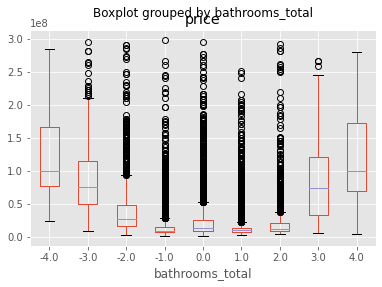

In [ ]:
X_train.boxplot('price', by='bathrooms_total')

#Target encoding (not used)

In [ ]:
from category_encoders.target_encoder import TargetEncoder
from sklearn.model_selection import StratifiedKFold
def kfoldTargetEncoder(train, train_y, test, cat_features, splits, smoothing=0.2):
    train_enc_df = pd.DataFrame([])
    kfold = StratifiedKFold(n_splits=splits, random_state=42, shuffle=True)
    print("here")
    #bins = np.linspace(0, len(train_y), 50)
    #train_y = np.digitize(train_y, bins)
    #print(train_y)
    #y_train_g = pd.DataFrame()
    #y_train_g['price'] = train_y
    #train_y = y_train_g
    #print(train_y)
    #print("HERER")

    for count, (train_idx, oof_idx) in enumerate(kfold.split(train, train_y)):
        targetEncoder = TargetEncoder(cols=cat_features, smoothing=smoothing)
        targetEncoderfit(train.iloc[train_idx,:], train_y.iloc[train_idx])
        train_transformed = targetEncoder.transform(train.iloc[oof_idx, :])
        train_enc_df = train_enc_df.append(train_transformed, ignore_index=False)
        print(f'Encoded fold {count+1}/{splits}')

    encoder = TargetEncoder(cols = cat_features, smoothing=smoothing)
    encoder.fit(train, train_y)
    test_enc = encoder.transform(test)

    return train_enc_df.sort_index(), test_enc


In [ ]:
X_train = stored_data_all[stored_data_all['Split']=='Train']
X_test = stored_data_all[stored_data_all['Split']=='Test']

In [ ]:
y_train = pd.DataFrame()
y_train['price'] = X_train[X_train['Split']=='Train'].price
X_train = X_train.drop('price', axis=1)
X_test = X_test.drop('price', axis=1)

In [ ]:
correct = []
for col in target_encode_columns:
  if col != 'price':
    correct.append(col)
correct

In [ ]:
train, test = KFoldTargetEncoder(X_train, y_train, X_test, correct, 7, 0.2)


Train and test and y_train could then be used to train a model and predict.

In [ ]:
columns = train.columns
columns = [column for column in columns if train[column].min()>1000000]
columns

['seller',
 'floor',
 'rooms',
 'bathrooms_shared',
 'bathrooms_private',
 'windows_court',
 'windows_street',
 'balconies',
 'loggias',
 'condition',
 'phones',
 'new',
 'district',
 'material',
 'stories',
 'elevator_without',
 'elevator_passenger',
 'elevator_service',
 'parking',
 'garbage_chute',
 'heating',
 'cluster_number']

In [ ]:
stored_train = deepcopy(train)
stored_test = deepcopy(test)

In [ ]:
for col in columns:
  test[col] = np.log2(test[col])
test

,seller,area_total,floor,rooms,ceiling,bathrooms_shared,bathrooms_private,windows_court,windows_street,balconies,loggias,condition,phones,new,latitude,longitude,district,street,address,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating,scaled_distance_center,theta,cluster_number
0,24.540693,71.4,24.294853,23.295017,3.136896,23.743531,24.459757,24.454147,23.788390,24.524447,24.281849,24.526224,24.395954,24.612360,55.762247,37.549040,26.234293,109,15.119404,2017.0,24.794408,24.461230,24.942913,24.455664,24.504819,25.248980,24.503241,24.442622,0.303790,2.033786,25.868398
1,23.996488,54.0,24.505014,23.295017,3.000000,23.743531,24.046611,24.454147,23.788390,24.524447,24.392373,25.804016,24.395954,24.612360,55.591467,37.452651,22.808847,1758,49.616688,2017.0,24.794408,24.358783,23.970645,24.455664,24.504819,25.248980,24.210326,24.442622,1.220339,-2.006395,22.893274
2,24.540693,39.4,24.380966,23.295017,2.650000,23.743531,24.459757,24.454147,23.788390,24.524447,24.392373,24.246133,24.395954,24.019073,55.617017,37.413718,22.808847,871,27.000000,2021.0,23.088161,23.602573,23.970645,24.455664,24.504819,23.477044,24.210326,24.442622,1.121034,-2.209276,22.733152
3,24.540693,60.9,24.565590,23.711954,2.803828,23.743531,24.459757,24.352492,24.696756,24.524447,24.392373,24.526224,24.395954,24.612360,55.569052,37.479510,22.808847,1375,23.000000,2014.0,24.794408,23.729569,24.942913,24.455664,24.253083,23.477044,24.503241,25.665242,1.350757,-1.878611,22.893274
4,24.540693,34.0,24.081462,23.295017,2.750000,23.743531,24.459757,24.454147,23.788390,24.063710,24.392373,23.170338,24.395954,24.612360,55.518041,37.343829,22.808847,1323,14.469772,2016.0,24.794408,23.729569,23.970645,24.455664,24.504819,23.477044,24.503241,24.442622,1.943133,-2.077554,22.557345
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9932,24.540693,106.0,24.457755,24.648110,3.300000,23.743531,24.459757,24.454147,24.696756,24.063710,24.392373,24.526224,24.395954,24.019073,55.789750,37.456468,24.239465,1695,43.921722,2020.0,24.794408,24.461230,23.970645,24.455664,24.504819,25.248980,24.503241,24.442622,0.702640,2.362385,24.777431
9933,24.540693,82.0,24.534084,24.648110,2.998076,25.517917,24.459757,24.454147,23.788390,24.524447,24.392373,23.170338,24.674028,24.019073,55.751639,37.516260,25.175133,430,53.479942,2021.0,24.794408,24.461230,23.970645,24.455664,24.504819,23.477044,24.210326,24.442622,0.323594,2.528478,24.150299
9934,24.540693,49.3,24.155014,23.295017,3.022527,23.743531,24.046611,24.454147,24.696756,24.524447,24.392373,24.526224,24.395954,24.019073,55.770659,37.375234,25.175133,854,73.418480,2016.0,24.794408,23.895409,23.970645,24.455664,24.504819,25.248980,24.503241,24.076036,0.887137,2.748650,24.774353
9935,24.540693,38.8,24.081462,23.295017,3.300000,23.743531,24.459757,24.352492,24.696756,24.063710,24.392373,24.526224,24.674028,24.612360,55.699943,37.637183,23.644413,1387,1.000000,2019.0,24.794408,23.738261,24.942913,24.455664,24.504819,25.248980,24.503241,24.442622,0.312930,-0.830295,24.088797


In [ ]:
for col in columns:
  train[col] = np.log2(train[col])
train

,seller,area_total,floor,rooms,ceiling,bathrooms_shared,bathrooms_private,windows_court,windows_street,balconies,loggias,condition,phones,new,latitude,longitude,district,street,address,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating,scaled_distance_center,theta,cluster_number
0,24.545442,59.2,24.280475,23.721929,2.650000,24.067980,24.873380,24.392892,24.699104,24.525827,24.385827,23.176299,24.401186,24.014964,55.544046,37.478055,22.815070,304,32.350388,2021.0,23.087618,23.594687,23.970274,24.458432,24.513561,23.471914,24.502034,24.063596,1.545808,-1.842580,22.756383
1,24.544304,88.0,24.448196,24.633949,2.752873,25.523519,24.462090,24.455797,24.704365,24.526328,24.284174,25.816879,24.403632,24.615912,55.861282,37.666647,23.636078,1729,21.176817,2010.0,23.090914,23.740081,23.967355,24.458861,24.505402,23.476346,24.504646,24.443035,1.119838,1.274427,23.295497
2,24.544843,78.5,24.169177,24.657781,2.650000,24.064577,24.866563,24.464676,24.698724,24.532546,24.394499,24.522539,24.399494,24.018391,55.663299,37.515335,23.978075,871,38.000000,2021.0,23.085380,24.339489,23.955993,24.455441,24.506211,23.475317,24.509872,24.101145,0.591095,-2.041925,24.674764
3,24.526840,88.0,24.487453,24.642797,2.687073,24.077786,24.823032,24.441356,24.687045,24.055359,24.388852,24.233720,24.387542,24.599218,55.861282,37.666647,23.623917,1729,21.294613,2010.0,23.090063,23.755179,23.974503,24.443731,24.486574,23.479695,24.490749,24.435904,1.119838,1.274427,23.301715
4,23.986536,78.0,24.569493,23.721929,2.900000,23.751064,24.458780,24.451064,24.699104,24.071501,24.385827,25.801401,24.401186,24.616299,55.590785,37.451438,22.815070,1758,17.283905,2017.0,24.795183,24.360320,23.970274,24.458432,24.513561,23.471914,24.225720,24.445999,1.227344,-2.008028,22.892436
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23280,24.531574,65.0,24.541379,23.706306,3.000000,24.067284,24.038619,24.452135,23.788780,24.023725,24.391670,25.800735,24.386403,24.023489,55.770775,37.376626,25.155366,854,16.530848,2017.0,24.789006,23.902231,23.975830,24.451158,24.496363,25.244680,24.498872,24.065589,0.882441,2.745294,24.868276
23281,24.526840,56.9,24.537782,23.716975,3.344095,23.728879,24.033328,24.441356,24.687045,24.513656,24.388852,24.516708,24.387542,24.016283,55.785777,37.585790,24.127227,303,20.558634,2020.0,24.780192,24.464629,23.974503,24.443731,24.262975,25.234937,24.490749,24.435904,0.461780,1.551492,25.265242
23282,24.526840,73.4,24.466498,23.716975,3.185289,25.511593,24.454159,24.441356,24.687045,24.513656,24.388852,24.516708,23.899125,24.599218,55.753686,37.513143,25.145729,262,4.000000,2018.0,24.780192,23.907054,24.921033,24.443731,24.486574,25.234937,24.204918,24.435904,0.343190,2.509672,24.112937
23283,23.991786,100.8,24.515336,24.650064,2.879247,24.078290,24.055981,24.459831,24.700930,24.523704,24.395074,24.243636,23.891217,24.620643,55.611302,37.696741,23.640032,1087,20.684961,1997.0,24.796390,25.141094,23.975007,24.460545,24.512019,25.258108,24.507151,24.447325,1.045915,-1.130841,23.005242


# Models (old)


In [ ]:
model2 = RandomForestRegressor(
    n_estimators=300,
    criterion='mse',
    max_depth=12,
    min_samples_split=2,
    min_samples_leaf=2,
    min_weight_fraction_leaf=0.0,
    max_features='auto',
    min_impurity_decrease=0.0,
    n_jobs=5,
    random_state=42,
    verbose=1,
    warm_start=False,
    ccp_alpha=0.5,
    max_samples=None) # .fit(train, y_train)

In [ ]:
model4 = GradientBoostingRegressor(
    learning_rate=0.1,
    n_estimators=2000,
    subsample=1.0, 
    verbose=1,
    criterion='mse',  
    max_depth=12, 
    min_impurity_decrease=0.0, 
    init=None, 
    random_state=42, 
    alpha=0.9,
    validation_fraction=0.1,
    n_iter_no_change=3,
    tol=0.0001,
    ccp_alpha=0.0) #.fit(X_train, y_train)

In [ ]:
#model5 = XGBRegressor(n_iterations_no_change=3,colsample_bytree= 0.6, gamma= 0.5, learning_rate= 0.05, min_child_weight=10, max_depth= 5,subsample=0.8)
from xgboost import XGBRegressor
model5 = XGBRegressor(learning_rate= 0.23, max_depth= 10, subsample=1, gamma= 2)

# Parameter tuning RandomizedSearchCV


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
params = {
        'min_child_weight': [1, 10],
        'gamma': [0.5, 1, 2],
        'colsample_bytree': [0.6, 1.0],
        'learning_rate': [0.05, 0.1]
        }
clf = RandomizedSearchCV(model5, params, n_jobs=-1, verbose=3)
clf.fit(train, y_train_data)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  6.3min finished


[13:11:16] WARNING: ../src/learner.cc:573: 
Parameters: { "n_iterations_no_change" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None...
                                          scale_pos_weight=None, subsample=None,
                                          tree_method=None,
                                          validate_parameters=None,
                        

best params xgboost:
{'colsample_bytree': 1.0,
 'gamma': 0.5,
 'learning_rate': 0.1,
 'max_depth': 5,
 'min_child_weight': 10,
 'subsample': 1.0}


 {'colsample_bytree': 0.6,
 'gamma': 1,
 'learning_rate': 0.05,
 'max_depth': 5,
 'min_child_weight': 1,
 'subsample': 0.8}

# K_fold testing and Optuna parameter tuning

In [ ]:
def root_mean_squared_log_error(y_true, y_pred):
    # Alternatively: sklearn.metrics.mean_squared_log_error(y_true, y_pred) ** 0.5
    assert (y_true >= 0).all() 
    assert (y_pred >= 0).all()
    log_error = np.log1p(y_pred) - np.log1p(y_true)  # Note: log1p(x) = log(1 + x)
    return np.mean(log_error ** 2) ** 0.5

In [ ]:
stored_data_all.to_csv(r'stored_data_all.csv')
data_all_cat.to_csv(r'data_all_cat.csv')

In [ ]:
X_train = stored_data_all[stored_data_all['Split']=='Train']
X_test = stored_data_all[stored_data_all['Split']=='Test']

In [ ]:
y_train = X_train.price
X_train = X_train.drop('price', axis=1)

In [ ]:
X_train = X_train.drop(['id', 'building_id', 'Split'], axis=1)

In [ ]:
X_test = X_test.drop(['id', 'building_id', 'Split'], axis=1)

In [ ]:
X_test = X_test.drop('price', axis=1)

In [ ]:
data_all_cat

,id,seller,price,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,bathrooms_shared,bathrooms_private,windows_court,windows_street,balconies,loggias,condition,phones,building_id,new,latitude,longitude,district,street,address,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating,Split,MSU,MSUCE,BMSTU,IUFS,LIS,NW,MUG,KKAR,IESR,RCTU,MEI,MPU,SW,IETVS,CENTER,cluster_number
0,0,1.0,7139520.0,59.2,12.5,31.0,2.0,2.0,NaN,2.65,0.0,2.0,0.0,1.0,NaN,NaN,NaN,1.0,4076,1.0,55.544046,37.478055,11.0,304,2187,2021.0,3.0,9.0,0.0,1.0,1.0,1.0,NaN,NaN,Train,18.111865,38.010013,27.951770,11.870307,39.304628,29.775580,29.710859,22.400143,35.060803,35.247152,25.844792,23.464999,12.028155,20.876708,24.995381,65
1,1,NaN,10500000.0,88.0,14.2,48.0,18.0,3.0,1.0,NaN,2.0,0.0,1.0,1.0,1.0,0.0,3.0,1.0,1893,0.0,55.861282,37.666647,2.0,1729,364,2010.0,3.0,25.0,0.0,1.0,1.0,1.0,NaN,0.0,Train,19.533059,2.547822,10.653579,26.340436,6.750784,11.272004,17.379333,23.523682,12.327268,15.709482,13.197512,15.374732,25.618077,22.513163,12.326286,23
2,2,1.0,9019650.0,78.5,22.5,40.8,12.0,3.0,NaN,2.65,0.0,2.0,1.0,1.0,NaN,NaN,NaN,1.0,5176,1.0,55.663299,37.515335,6.0,871,1146,2021.0,3.0,15.0,0.0,1.0,1.0,1.0,NaN,NaN,Train,4.628625,24.991497,15.650362,6.264921,25.825705,16.430508,20.339160,16.074171,23.969873,22.631718,12.423439,12.011991,1.661160,10.104800,12.021881,39
3,3,NaN,10500000.0,88.0,14.0,48.0,18.0,3.0,NaN,NaN,0.0,2.0,1.0,1.0,0.0,1.0,2.0,1.0,1893,0.0,55.861282,37.666647,2.0,1729,364,2010.0,3.0,25.0,0.0,1.0,1.0,1.0,NaN,0.0,Train,19.533059,2.547822,10.653579,26.340436,6.750784,11.272004,17.379333,23.523682,12.327268,15.709482,13.197512,15.374732,25.618077,22.513163,12.326286,23
4,4,NaN,13900000.0,78.0,17.0,35.0,7.0,2.0,1.0,2.90,1.0,0.0,1.0,1.0,0.0,1.0,3.0,1.0,6604,0.0,55.590785,37.451438,11.0,1758,606,2017.0,2.0,15.0,0.0,1.0,1.0,1.0,0.0,0.0,Train,13.517872,34.007596,24.438289,9.870446,34.507853,24.782501,27.712964,21.463420,32.294731,29.909488,20.972263,20.347375,7.394659,15.428755,21.009646,73
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9932,33217,1.0,NaN,106.0,19.9,56.7,16.0,3.0,NaN,3.30,1.0,0.0,NaN,NaN,0.0,1.0,NaN,1.0,4252,1.0,55.789750,37.456468,8.0,1695,71,2020.0,2.0,20.0,0.0,1.0,1.0,0.0,NaN,0.0,Test,10.515605,17.555014,14.582190,19.923091,13.655803,4.131266,23.560505,24.572269,22.845900,8.085602,4.473483,15.542601,15.637553,7.925068,11.001288,36
9933,33218,NaN,NaN,82.0,NaN,NaN,3.0,3.0,NaN,NaN,2.0,0.0,1.0,0.0,NaN,NaN,1.0,2.0,7380,1.0,55.751639,37.516260,7.0,430,2015,2021.0,2.0,20.0,0.0,1.0,1.0,1.0,NaN,NaN,Test,5.321818,16.996794,10.719495,14.557400,16.140509,6.601784,19.010185,19.069432,19.634236,13.478993,2.610483,10.408307,11.210033,7.859205,6.501047,93
9934,33219,NaN,NaN,49.3,NaN,NaN,15.0,1.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,1480,1.0,55.770659,37.375234,7.0,854,1667,2016.0,2.0,24.0,0.0,1.0,1.0,0.0,1.0,1.0,Test,12.098199,23.067652,19.452311,20.954045,18.468046,9.601405,28.075381,27.819939,28.051136,10.123967,9.263245,19.498814,15.401594,5.177510,15.462811,70
9935,33220,NaN,NaN,38.8,10.5,15.1,14.0,1.0,NaN,3.30,1.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,2154,0.0,55.699943,37.637183,5.0,1387,1,2019.0,NaN,14.0,1.0,1.0,1.0,0.0,1.0,NaN,Test,6.899013,18.350186,7.961998,8.436113,21.833410,14.682821,11.754497,9.587889,15.449759,22.478018,11.010539,3.483124,10.214877,15.221214,6.092644,52


In [ ]:
y_train

0         7139520.0
1        10500000.0
2         9019650.0
3        10500000.0
4        13900000.0
            ...    
22799    13300000.0
22800    15854300.0
22801    19800000.0
22802    29999000.0
22803    10950000.0
Name: price, Length: 22804, dtype: float64

In [ ]:
pip install optuna

In [ ]:
import xgboost
xgboost.__version__

'0.90'

In [ ]:
import optuna
import lightgbm as lgb
def objective(trial,data=X_train,target=y_train):
 
    #Loading the dataset

    #train = train.drop('Split', axis=1)
    y_mean = np.log2(target.mean())
    y = deepcopy(np.log2(target.to_numpy()))
    X = deepcopy(data)
    
    #Implementing cross validation
    k = 3
    kf = KFold(n_splits=3, shuffle=True, random_state=42)

    param = {
        'n_estimators': trial.suggest_categorical('n_estmators', [3000,5000,6500,7000,9000]),
        'max_depth': trial.suggest_categorical('max_depth', [3,4,5,6,8,10,12]),
        'learning_rate':trial.suggest_categorical('learning_rate', [0.001,0.06,0.1, 0.14, 0.3,0.5]),
        #'min_samples_leaf':trial.suggest_categorical('min_samples_leaf', [1,2,4,6,9,12]),
        #'num_leaves': trial.suggest_categorical('num_leaves', [4,17,21,24,27,50]),
        #'boosting': trial.suggest_categorical('boosting', ['gbdt', 'dart']),
        #'booster': trial.suggest_categorical('booster', ['gbtree', 'dart']),'reg:squaredlogerror',
        #'objective': trial.suggest_categorical('objective', ['reg:squarederror']),
        'min_child_wheight': trial.suggest_categorical('min_child_wheight', [0,0.5,2,6,15,30,70,300,1000]),
        'n_jobs': -1,
        'seed': 42,
    }

#     model4 = xgb.XGBRegressor(
#     n_estimators=5000,
#     learning_rate=0.14,
#     max_depth = 4,
#     n_iter_no_change = 3,
#     n_jobs=-1, 
#     random_state=SEED,
#     seed=SEED,
#     verbosity=1,
# )
#min_child_wheight
#objective til reg:squaredlogerror

#     model3 = lgb.LGBMRegressor(
#     n_estimators=6000,
#     learning_rate=0.08,
#     num_leaves=10,
#     random_state=SEED,
#     n_jobs=-1,
# )
#Trial 25 finished with value: 0.12818131318606005 and parameters: {'n_estmators': 7000, 'max_depth': None, 'learning_rate': 0.06, 'num_leaves': 24}. Best is trial 25 with value: 0.12818131318606005.

    model = xgb.XGBRegressor(**param)
    
    acc_score = []

    for train_index , test_index in kf.split(X):
        X_train_k , X_test_k = X.iloc[train_index,:],X.iloc[test_index,:]
        y_train_k , y_test_k = y[train_index] , y[test_index]
        
        model.fit(X_train_k,y_train_k)
      
        pred_values = model.predict(X_test_k)
        pred_values = np.power(2, pred_values)
        acc = root_mean_squared_log_error(y_true=np.power(2, y_test_k), y_pred=pred_values)
        acc_score.append(acc)
        
    avg_acc_score = sum(acc_score)/k
      
    return avg_acc_score

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

study.trials_dataframe()

[I 2021-11-15 20:50:21,255] A new study created in memory with name: no-name-ed09dfef-100e-4f30-aec4-6d6816cfd20e


[20:50:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:50:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:50:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-11-15 20:51:03,463] Trial 0 finished with value: 0.8380219032391215 and parameters: {'n_estmators': 3000, 'max_depth': 3, 'learning_rate': 0.001, 'min_child_wheight': 1000}. Best is trial 0 with value: 0.8380219032391215.


[20:51:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:51:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:52:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


KeyboardInterrupt: ignored

RandomForest: {'n_estmators': 5000, 'max_depth': None, 'max_features': 20}. Best is trial 19 with value: 0.15231897374233164


LigthGBM: Trial 25 finished with value: 0.12818131318606005 and parameters: {'n_estmators': 7000, 'max_depth': None, 'learning_rate': 0.06, 'num_leaves': 24}. Best is trial 25 with value: 0.12818131318606005.

ELLER

Trial 49 finished with value: 0.12454328037700241 and parameters: {'n_estmators': 9000, 'max_depth': None, 'learning_rate': 0.1, 'num_leaves': 17, 'boosting': 'dart'}. Best is trial 41 with value: 0.12454292837804443.

In [ ]:
from sklearn.model_selection import KFold 
from sklearn.metrics import mean_squared_log_error
 
#Loading the dataset

#train = train.drop('Split', axis=1)
y_mean = np.log2(y_train.mean())
y = deepcopy(np.log2(y_train.to_numpy()))
X = deepcopy(X_train)
 
#Implementing cross validation
k = 3
kf = KFold(n_splits=3, shuffle=True, random_state=42)
 
acc_score = []

for train_index , test_index in kf.split(X):
    X_train_k , X_test_k = X.iloc[train_index,:],X.iloc[test_index,:]
    y_train_k , y_test_k = y[train_index] , y[test_index]
     
    model1.fit(X_train_k,y_train_k)
    # #model2.fit(X_train_k,y_train_k)
    # model3.fit(X_train_k,y_train_k)
    # model4.fit(X_train_k,y_train_k)
   
    pred_values = model1.predict(X_test_k)
    # #pred2_values = model2.predict(X_test_k)
    # pred3_values = model3.predict(X_test_k)
    # pred4_values = model4.predict(X_test_k)
    # pred_values = np.average(
    #     [pred1_values,
    #      #pred2_values,
    #      pred3_values,
    #      pred4_values
    #     ],
    #     axis=0
    # )   
    pred_values = np.power(2, pred_values)
    acc = root_mean_squared_log_error(y_true=np.power(2, y_test_k), y_pred=pred_values)
    print(acc)
    acc_score.append(acc)
     
avg_acc_score = sum(acc_score)/k
 
print('accuracy of each fold - {}'.format(acc_score))
print('Avg accuracy : {}'.format(avg_acc_score))

Kun RandomForest: accuracy of each fold - [0.15463563599944982, 0.15240979978324476, 0.1500104813278971]
Avg accuracy : 0.15235197237019724


KUN GRADIENTBOOST: accuracy of each fold - [0.15362124260894527, 0.1522466354445527, 0.1451283145019559]
Avg accuracy : 0.1503320641851513





Avg accuracy : 0.1578595030284066


# Model Interpretation ( feature importance)

## Feature Importance

**Measuring feature importance was used in combination with testing on cross validation, to decide which features to drop for the different models**

In [ ]:
X_train_importance_cat, X_test_importance_cat, y_train_importance_cat, y_test_importance_cat = train_test_split(X_cat, y, test_size=0.33, random_state=42)
X_train_importance, X_test_importance, y_train_importance, y_test_importance = train_test_split(X, y, test_size=0.33, random_state=42)

### RandomForestRegressor

In [ ]:
model1.fit(X_train_importance, y_train_importance)

In [ ]:
perm_importance = permutation_importance(model1, X_test_importance, y_test_importance)
sorted_idx = perm_importance.importances_mean.argsort()
fig = plt.figure(figsize=(8, 8))
plt.barh(X_train_importance.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
fig.set_size_inches(12, 20)
plt.show()

### GradientBoostingRegressor

In [ ]:
model2.fit(X_train_importance, y_train_importance)

In [ ]:
feature_importance = model2.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(8, 8))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(X_train_importance.columns)[sorted_idx])
plt.title('Feature Importance (MDI)')
result = permutation_importance(model2, X_test_importance, y_test_importance, n_repeats=10, random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
fig.tight_layout()
fig.set_size_inches(12, 20)
plt.show()

### LightGBM

In [ ]:
model3.fit(X_train_importance_cat, y_train_importance_cat)

In [ ]:
ax = lgb.plot_importance(model3, max_num_features=200)
fig = ax.figure
fig.set_size_inches(12, 20)
plt.show()

### XGBoost

In [ ]:
model4.fit(X_train_importance, y_train_importance)

In [ ]:
ax = plot_importance(model4)
fig = ax.figure
fig.set_size_inches(12, 20)

### CatBoost

In [ ]:
model5.fit(X_train_importance_cat, y_train_importance_cat)

In [ ]:
shap_values = model5.get_feature_importance(Pool(X_test_importance_cat, label=y_test_importance_cat), type="ShapValues")
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]

shap.initjs()
shap.force_plot(expected_value, shap_values[3,:], X_test_importance_cat.iloc[3,:])

In [ ]:
shap.summary_plot(shap_values, X_test_importance_cat, max_display=X_test_importance_cat.shape[1])

## PDP

In [ ]:
from sklearn.inspection import partial_dependence
from sklearn.inspection import PartialDependenceDisplay

tic = time()
features = ['area_total', 'area_kitchen', 'MSU', 'lat_long_clustering']
display = PartialDependenceDisplay.from_estimator(
    model1,
    X_train,
    features,
    kind="both",
    subsample=50,
    n_jobs=-1,
    grid_resolution=20,
    random_state=0,
    ice_lines_kw={"color": "tab:blue", "alpha": 0.2, "linewidth": 0.5},
    pd_line_kw={"color": "tab:orange", "linestyle": "--"},
)
tic = time()
features = ['area_total', 'area_kitchen', 'MSU', 'lat_long_clustering']
display = PartialDependenceDisplay.from_estimator(
    model2,
    X_train,
    features,
    kind="both",
    subsample=50,
    n_jobs=-1,
    grid_resolution=20,
    random_state=0,
    ice_lines_kw={"color": "tab:blue", "alpha": 0.2, "linewidth": 0.5},
    pd_line_kw={"color": "tab:orange", "linestyle": "--"},
)
tic = time()
features = ['area_total', 'area_kitchen', 'MSU', 'lat_long_clustering']
display = PartialDependenceDisplay.from_estimator(
    model3,
    X_train,
    features,
    kind="both",
    subsample=50,
    n_jobs=-1,
    grid_resolution=20,
    random_state=0,
    ice_lines_kw={"color": "tab:blue", "alpha": 0.2, "linewidth": 0.5},
    pd_line_kw={"color": "tab:orange", "linestyle": "--"},
)
tic = time()
features = ['area_total', 'area_kitchen', 'MSU', 'lat_long_clustering']
display = PartialDependenceDisplay.from_estimator(
    model4,
    X_train,
    features,
    kind="both",
    subsample=50,
    n_jobs=-1,
    grid_resolution=20,
    random_state=0,
    ice_lines_kw={"color": "tab:blue", "alpha": 0.2, "linewidth": 0.5},
    pd_line_kw={"color": "tab:orange", "linestyle": "--"},
)
print(f"done in {time() - tic:.3f}s")
display.figure_.subplots_adjust(hspace=0.3)